In [1]:
import spacy
from spacy.language import Language
from spacy import displacy
import time
import re
import math
import statistics
import os
import json
import calendar
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
from icecream import ic

In [123]:
alias = {"MAUS":"MONTHLY ACTIVE USERS", "ARR":"ANNUAL RECURRING REVENUE", "ARPU":"ACTIVE REVENUE PER USER"}
alias["NET DOLLAR EXPANSION CUSTOMERS WITH MORE THAN 10 EMPLOYEES"] = "NET DOLLAR EXPANSION"
alias["NON-GAAP DILUTED EPS"] = "EPS"
alias["GAAP DILUTED EPS"] = "GAAP-EPS"
alias["NON-GAAP NET INCOME PER SHARE"] = "EPS"
alias["GAAP NET INCOME PER SHARE"] = "GAAP-EPS"
alias["NON-GAAP EARNING PER SHARE"] = "EPS"
alias["GAAP EARNING PER SHARE"] = "GAAP-EPS"
print(alias)

paraBreak = "PG*** "
print(paraBreak)

sepBreak = ": "
print(sepBreak)

dsep = ":"
print(dsep)

moneyType = ["REVENUE", "EPS"]
print(moneyType)

millnames = ['','T','MN','BN','TN']
print(millnames)

cdType = ["MAUS", "MAU"]
print(cdType)

unitSkip = ["PER SHARE", "ARPU"]
print(unitSkip)

posBias = ["EXPENSE", "EXPENSES"]
print(posBias)

famousInst = ["FISHER","COOPERMAN","ARK","BAILLIE GIFFORD","BERKSHIRE","GOLDMAN SACHS","SUSQUEHANNA","MORGAN STANLEY","RENAISSANCE","JP MORGAN"]
print(famousInst)

{'MAUS': 'MONTHLY ACTIVE USERS', 'ARR': 'ANNUAL RECURRING REVENUE', 'ARPU': 'ACTIVE REVENUE PER USER', 'NET DOLLAR EXPANSION CUSTOMERS WITH MORE THAN 10 EMPLOYEES': 'NET DOLLAR EXPANSION', 'NON-GAAP DILUTED EPS': 'EPS', 'GAAP DILUTED EPS': 'GAAP-EPS', 'NON-GAAP NET INCOME PER SHARE': 'EPS', 'GAAP NET INCOME PER SHARE': 'GAAP-EPS', 'NON-GAAP EARNING PER SHARE': 'EPS', 'GAAP EARNING PER SHARE': 'GAAP-EPS'}
PG*** 
: 
:
['REVENUE', 'EPS']
['', 'T', 'MN', 'BN', 'TN']
['MAUS', 'MAU']
['PER SHARE', 'ARPU']
['EXPENSE', 'EXPENSES']
['FISHER', 'COOPERMAN', 'ARK', 'BAILLIE GIFFORD', 'BERKSHIRE', 'GOLDMAN SACHS', 'SUSQUEHANNA', 'MORGAN STANLEY', 'RENAISSANCE', 'JP MORGAN']


In [3]:
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [4]:
def getOrgData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [5]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [6]:
def getOrgEst(orgData, attr):
    if not orgData:
        return None
    newAttr = "ANALYSIS|"+attr+"-EST"
    val = getOrgAttr(orgData, newAttr)
    return(val)

In [7]:
data = getOrgData("PINS")
val = getOrgAttr(data, "ORGPROFILE|FiscalYearEnd")
print(val)
dobj = datetime.strptime(val, "%B")
print(dobj.month)

December
12


In [8]:
def getQtrs(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"]):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(qtrs["Q1"]["START"] > qtrs["Q4"]["END"]):
        if(qtrs["CQTR"] > qtrs["EQTR"]):
            qtrs["FYR"] = str(year + 1)
        else:
            qtrs["FYR"] = str(year)
    else:
        if(qtrs["CQTR"] > qtrs["EQTR"]):
            qtrs["FYR"] = str(year)
        else:
            qtrs["FYR"] = str(year - 1)
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [9]:
#getQtrs("PINS", "2021-10-20", 12)
getQtrs("ZM", "2021-11-22", 1)
#getQtrs("PINS", "2022-02-22", 12)

{'Q1': {'START': 2, 'SM': 'FEB', 'END': 4, 'EM': 'APR'},
 'Q2': {'START': 5, 'SM': 'MAY', 'END': 7, 'EM': 'JUL'},
 'Q3': {'START': 8, 'SM': 'AUG', 'END': 10, 'EM': 'OCT'},
 'CQTR': 'Q4',
 'GQTR': 'Q4',
 'CYR': '2022',
 'GYR': '2022',
 'EQTR': 'Q3',
 'PQTR': 'Q2',
 'Q4': {'START': 11, 'SM': 'NOV', 'END': 1, 'EM': 'JAN'},
 'EYR': '2021',
 'PYR': '2021',
 'FYR': '2022'}

In [10]:
def getCurrency(csym):
    orgData = getOrgData(csym)
    if not orgData:
        currency = "$"
    currency = getOrgAttr(orgData, "ORGPROFILE|Currency")
    if not currency:
        currency = "$"
    elif currency == "USD":
        currency = "$"
    return currency

In [11]:
def getMetricTbl(tbls, tblType, metric):
    if "PARSESUCCESS" not in tbls:
        return None
    for i,v in enumerate(tbls["PARSESUCCESS"]):
        #print(v)
        if str(v) in tbls and "PARSE" in tbls[str(v)]:
            parse = tbls[str(v)]["PARSE"]
            for j,k in enumerate(parse):
                tType = k["TABLENAME"]
                #unit = k["UNIT"]
                if(tType == tblType):
                    if(metric and metric in k["METRICS"]):
                        return k
                    elif not metric: #return entire table
                        return k
                    #print(k["METRICS"])
                    #tbl = pd.read_json(k["TABLE"])
                    #break
    return None

In [12]:
def getMetricVal(tb, metric):
    if(tb is not None):
        tbl = pd.read_json(tb["TABLE"])
        unit = tb["UNIT"]
        index = list(tbl["METRIC"]).index(metric)
        val = tbl.iloc[index,1]
        val = str(val).replace(",","")
        #if "PER SHARE" not in metric and "ARPU" not in metric:
        if all(x not in metric for x in unitSkip):
            if unit == "T":
                temp = re.findall('\d*\.?\d+', (val))
                if(len(temp) > 0):
                    nval = float(temp[0]) * 10**3
                    if(not str(val)[0].isdigit()):
                        val = str(val)[0]+millify(nval)
                    else:
                        val = millify(nval)
                else:
                    val = str(val)+unit
            else:
                if(unit == "M"):
                    val = str(val)+"MN"
                else:
                    val = str(val)+"BN"
        #print(tbl.iloc[index,1])
        return val
    return None

In [13]:
def fillEntity(metric, val, mtype, eqtr, moreEntity, metricType=None):
    sentence = metric+" is " + str(val) + " in " + eqtr
    moreEntity[metric] = list()
    moreEntity[metric].append(("-1","LINE",-1,-1))
    moreEntity[metric].append(("REGULAR","SECTION",-1,-1))
    moreEntity[metric].append((str(val),mtype,-1,-1))
    moreEntity[metric].append((eqtr,"CALENDAR",-1,-1))
    if(metricType):
        moreEntity[metric].append((metricType,"METRICTYPE",-1,-1))
    moreEntity[metric].append((sentence,"SENTENCE",-1,-1))
    return moreEntity

In [14]:
def getMetric(tbls, tblType, metric):
    tb = getMetricTbl(tbls, tblType, metric)
    if tb:
        val = getMetricVal(tb,metric)
        return val
    return None

In [15]:
def getAllMetrics(tbls, tblType, eqtr, moreEntity):
    tb = getMetricTbl(tbls, tblType, None)
    metricType = None
    opmetrics = list()
    if tb:
        if(tblType == "OPMETRIC"):
            metricType = tblType
            opmetrics = opmetrics + tb["METRICS"]
        #print(tb["METRICS"])
        for i,metric in enumerate(tb["METRICS"]):
            val = getMetricVal(tb,metric)
            if val:
                mtype = "MONEY"
                if any(x in metric for x in cdType):
                    mtype = "CD"
                newMetric = metric
                for aval in alias:
                    if aval in metric:
                        newMetric = newMetric.replace(aval, alias[aval])
                        opmetrics.append(newMetric)
                        #print(newMetric)
                moreEntity = fillEntity(newMetric,str(val),mtype,eqtr,moreEntity,metricType)
    opmetrics = (list(set(opmetrics)))
    return moreEntity, opmetrics

In [16]:
def getOtherEntitiesFromTbls(csym, filename, eqtr):
    newFilename = filename.replace(csym, csym+"-REPORT")
    tblDest = "../../Summary/report/"+newFilename+".txt"
    opmetricFile = "../../Summary/OTHER/opmetric.json"
    moreEntity = dict()
    opmetrics = list()
    #print(tblDest)
    
    epsStr = "NON-GAAP NET INCOME PER SHARE"
    revStr = "REVENUE"
    spcTbl = "OPMETRIC"
    tbls = None
    
    file = Path(tblDest)
    if file.is_file():
        with open(tblDest) as f:
            tbls = json.load(f)
        #print(tbls["PARSESUCCESS"])
    if not tbls:
        return(moreEntity)
    
    opFile = Path(opmetricFile)
    if opFile.is_file():
        with open(opmetricFile) as f:
            opmetrics = json.load(f)
    
    val = getMetric(tbls, "ACCOUNTING", epsStr)
    if(val):
        moreEntity = fillEntity("EPS",str(val),"MONEY",eqtr,moreEntity)
    
    val = getMetric(tbls, "STMTOP", revStr)
    #print(val)
    if(val):
        moreEntity = fillEntity("REVENUE",str(val),"MONEY",eqtr,moreEntity)
    else:
        val = getMetric(tbls, "STMTOP", "TOTAL "+revStr)
        if(val):
            moreEntity = fillEntity("REVENUE",str(val),"MONEY",eqtr,moreEntity)
    
    moreEntity, newOpmetrics = getAllMetrics(tbls, spcTbl, eqtr, moreEntity)
    
    opmetrics = list(set(opmetrics + newOpmetrics))
    
    json_object = json.dumps(opmetrics, indent = 4)
  
    # Writing to sample.json
    with open(opmetricFile, "w") as outfile:
        outfile.write(json_object)
    
    return(moreEntity)

In [17]:
getOtherEntitiesFromTbls("PINS", "PINS-2021-11-04_12-53-41.533916", "Q3")

{'EPS': [('-1', 'LINE', -1, -1),
  ('REGULAR', 'SECTION', -1, -1),
  ('$0.28', 'MONEY', -1, -1),
  ('Q3', 'CALENDAR', -1, -1),
  ('EPS is $0.28 in Q3', 'SENTENCE', -1, -1)],
 'REVENUE': [('-1', 'LINE', -1, -1),
  ('REGULAR', 'SECTION', -1, -1),
  ('$633MN', 'MONEY', -1, -1),
  ('Q3', 'CALENDAR', -1, -1),
  ('REVENUE is $633MN in Q3', 'SENTENCE', -1, -1)],
 'REVENUE - GLOBAL': [('-1', 'LINE', -1, -1),
  ('REGULAR', 'SECTION', -1, -1),
  ('$633MN', 'MONEY', -1, -1),
  ('Q3', 'CALENDAR', -1, -1),
  ('OPMETRIC', 'METRICTYPE', -1, -1),
  ('REVENUE - GLOBAL is $633MN in Q3', 'SENTENCE', -1, -1)],
 'REVENUE - UNITED STATES': [('-1', 'LINE', -1, -1),
  ('REGULAR', 'SECTION', -1, -1),
  ('$498MN', 'MONEY', -1, -1),
  ('Q3', 'CALENDAR', -1, -1),
  ('OPMETRIC', 'METRICTYPE', -1, -1),
  ('REVENUE - UNITED STATES is $498MN in Q3', 'SENTENCE', -1, -1)],
 'REVENUE - INTERNATIONAL': [('-1', 'LINE', -1, -1),
  ('REGULAR', 'SECTION', -1, -1),
  ('$135MN', 'MONEY', -1, -1),
  ('Q3', 'CALENDAR', -1, -1),


In [18]:
def splitSentences(nlp, sent, lner):
    ss = list()
    doc = nlp(sent)
    
    date = None
    
    if(len(lner) > 0 and lner[0][1] == "DATE"):
        date = lner[0][0]

    #for i,token in enumerate(doc):
    #    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #            token.conjuncts, token.shape_, token.is_alpha, token.is_stop, i)
    #print(sent)
    #print("\n")
    start = -1
    end = -1
    prev_start = -1
    prev_chunk = None
    curr_chunk = None
    first = False
    prefix = None

    for chunk in doc.noun_chunks:
        #print(chunk.text, chunk.root.text, chunk.root.dep_,
        #        chunk.root.head.text)
        #print(chunk.text, chunk.root.dep_, chunk.start, chunk.end)
    
        if chunk.root.dep_ == "nsubj" or chunk.root.dep_ == "nsubjpass":
            #print(chunk.text, chunk.root.dep_, chunk.start, chunk.end)
        
            start = chunk.start
            if not first:
                if start > 0:
                    if(date and date in str(doc[0:start])):
                        prefix = date
                    start = 0
                first = True
                
            curr_chunk = chunk
            verb_cnt = 0
            if prev_start != -1:
                end = start
            if(end!=-1):
                #print(prev_start,end, start, doc[prev_start:end])
                text = None
                if prev_chunk:
                    text = prev_chunk.text
                sc = prev_start
                ec = -1
                pc = -1
                for i in range(prev_start,end):
                    token = doc[i]
                    if(token.pos_ == "VERB"):
                        verb_cnt = verb_cnt + 1
                    if(token.dep_ == "conj" and verb_cnt > 1 and token.pos_ == "VERB" and token.tag_ != "VB"):
                        #print(token.text,i)
                        ec = i
                        if (text): 
                            if(text in str(doc[sc:ec])):
                                #print(sc,ec,doc[sc:ec])
                                ss.append(str(doc[sc:ec]))
                            else:
                                #print(sc,ec, text + " " + str(doc[sc:ec]))
                                ss.append(text + " " + str(doc[sc:ec]))
                        else:
                            #print(sc,ec,doc[sc:ec])
                            ss.append(str(doc[sc:ec]))
                        sc = ec
                #if(sc>0 and sc!=prev_start):
                if(sc>=0):
                    #text = chunk.text
                    if(text):
                        if (text in str(doc[sc:end])):
                            #print(sc,end,doc[sc:end])
                            ss.append(str(doc[sc:end]))
                        else:
                            #print(sc,end, text + " " + str(doc[sc:end]))
                            ss.append(text + " " + str(doc[sc:end]))
                    else:
                        #print(sc,end,doc[sc:end])
                        ss.append(str(doc[sc:end]))
            prev_start = start
            prev_chunk = chunk
    
    if(start >= 0):
        #print(prev_start,len(doc), start, doc[start:len(doc)])
        text = curr_chunk.text
        end = len(doc)
        sc = prev_start
        ec = -1
        pc = -1
        verb_cnt = 0
        for i in range(prev_start,end):
            token = doc[i]
            if(token.pos_ == "VERB"):
                verb_cnt = verb_cnt + 1
            #text = token.text
            if(token.dep_ == "conj" and verb_cnt > 1 and token.pos_ == "VERB" and token.tag_ != "VB"):
                #print(token.text,i)
                ec = i
                if (text): 
                    if(text in str(doc[sc:ec])):
                        #print("HELLO", token.text, token.pos_, token.dep_)
                        #print(sc,ec,doc[sc:ec])
                        ss.append(str(doc[sc:ec]))
                    else:
                        #print("HELLO1")
                        #print(sc,ec, text + " " + str(doc[sc:ec]))
                        ss.append(text + " " + str(doc[sc:ec]))
                else:
                    #print("HELLO2")
                    #print(sc,ec,doc[sc:ec])
                    ss.append(str(doc[sc:ec]))
                sc = ec
            #if(sc>0 and sc!=prev_start):
        if(sc>=0):
            #text = token.text
            if (text):
                if (text in str(doc[sc:end])):
                    #print("HELLO3")
                    #print(sc,end,doc[sc:end])
                    if(prefix and prefix not in str(doc[sc:end])):
                        ss.append(prefix + " " + str(doc[sc:end]))
                    else:
                        ss.append(str(doc[sc:end]))
                else:
                    #print("HELLO4")
                    #print(sc,end, text + " " + str(doc[sc:end]))
                    ss.append(text + " " + str(doc[sc:end]))
            else:
                #print("HELLO5")
                #print(sc,end,doc[sc:end])
                if(prefix and prefix not in str(doc[sc:end])):
                    ss.append(prefix + " " + str(doc[sc:end]))
                else:
                    ss.append(str(doc[sc:end]))

    #print("\n")
    if (len(ss) == 0):
        ss.append(sent)
    
    print("Sentences\n", ss)
    return ss

In [19]:
def is_attr_for_metric(metric, attr, doc):
    if attr[1] == "LOC":
        value = attr[0]
        start = attr[2]
        end = attr[3]
        for chunk in doc.noun_chunks:
            if((value in chunk.text and start >= chunk.start and end <= chunk.end)):
                if(chunk.root.dep_ == "nsubj"):
                    return False
    return True

def is_earningReportLine(sent):
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises", "Announced", "Reported"]
    words2 = ["Earnings", "Results"]
    if any(word.upper() in sent.upper() for word in words1) and any(word.upper() in sent.upper() for word in words2):
        #print(True)
        return True
    return False

def get_section(text):
    table = ["following table", "CONSOLIDATED BALANCE SHEETS", "CONSOLIDATED STATEMENTS OF OPERATIONS", "CONDENSED CONSOLIDATED"]
    guide = ["expect", "expectation", "will grow", "will decline", "forecast", "is expected", "financial targets", "following guidance"]
    compare = ["compared with", "compared to", "up from"]
    guideFull = ["Full Fiscal", "FULL FISCAL", "FULL YEAR"]
    
    if is_earningReportLine(text):
        return "EARNING"
    
    if(any(word.upper() in text.upper() for word in guide)):
        if(any(word.upper() in text.upper() for word in guideFull)):
            return "GUIDEFULL"
        return "GUIDE"
    
    if(any(word.upper() in text.upper() for word in table)):
        return "TABLE"
    
    if(any(word.upper() in text.upper() for word in compare)):
        return "COMPARE"
    
    return "REGULAR"

def is_found_param(v):
    if v[1] == "MONEY" or v[1] == "PCT" or v[1] == "CD" or v[1] == "CHG":
        return True
    return False

def is_valid_param(v):
    if v[1] == "CS" or v[1] == "PER" or v[1] == "ROLE":
        return False
    return True

def get_metric(metric_arr, doc):
    global alias
    metric = ""
    end = -1
    if(len(metric_arr) == 0):
        return None
    if(len(metric_arr) == 1):
        if metric_arr[0][0] in alias:
            return alias[metric_arr[0][0]]
        return(metric_arr[0][0])
    else:
        metric = metric_arr[0][0]
        if metric in alias:
            metric = alias[metric]
        for i,v in enumerate(metric_arr):
            start = v[2]
            end = -1
            sep = " "
            if i+1 < len(metric_arr):
                #print(metric_arr[i+1])
                end = metric_arr[i+1][1]
            #print(start, end)
            if end != -1:
                for index, token in enumerate(doc):
                    if(index < start):
                        continue
                    elif(index > end):
                        break
                    else:
                        if (token.text.upper() == "AND"):
                            sep = " AND "
                            break
                        elif (token.text.upper() == ":" and ((end-start) <= 2)):
                            sep = None
                            metric = metric_arr[i+1][0]
                            if metric in alias:
                                metric = alias[metric]
                            break
                if sep:
                    if metric_arr[i+1][0] in alias:
                        metric = metric + sep + alias[metric_arr[i+1][0]]
                    else:
                        metric = metric + sep + metric_arr[i+1][0]
            #else:
            #    metric = metric + sep + v[0]
    return(metric)

def insert_other_items(entity, v):
    if(v[1] == "ORG"):
        if("ORG" not in entity):
            entity["ORG"] = list()
        entity["ORG"].append(v[0].upper())
    elif(v[1] == "MISC"):
        if("MISC" not in entity):
            entity["MISC"] = list()
        entity["MISC"].append(v[0].upper())
    elif(v[1] == "SYM"):
        if("SYM" not in entity):
            entity["SYM"] = list()
        entity["SYM"].append(v[0].upper())
    elif(v[1] == "CALENDAR"):
        if("CALENDAR" not in entity):
            entity["CALENDAR"] = list()
        if "YEAR" not in v[0].upper():
            entity["CALENDAR"].append(v[0].upper())
    elif(v[1] == "DATE"):
        if("DATE" not in entity):
            entity["DATE"] = list()
        entity["DATE"].append(v[0].upper())
    return(entity)

def is_metric_subj(v, prev_metric, entity, doc, section, e):
    metric = v[0]
    start = v[2]
    end = v[3]
    #found = False
    
    if section == "TABLE":
        #print("HELLLOOOOOO111111")
        return True
    
    if not prev_metric:
        #print("HELLLOOOOOO")
        return True
    
    for chunk in doc.noun_chunks:
        #print(chunk.text, chunk.root.dep_)
        if((metric in chunk.text and end <= chunk.end) or (chunk.text in metric and chunk.start >= start and chunk.end <= end)):
            #print(chunk.text, chunk.root.dep_, metric, chunk.start, chunk.end)
            if(chunk.root.dep_ == "ROOT" or chunk.root.dep_ == "nsubj" or chunk.root.dep_ == "nsubjpass" or chunk.root.dep_ == "conj"):
                #print(metric, chunk.root.dep_)
                return True
            #print(metric, chunk.root.dep_)
            #print("HELLLOOOOOO2222222")
            return False
            #break

    if(prev_metric and prev_metric in entity):
        #v = entity[prev_metric][-1]
        v = e[-1]
        #print("Hello", v, metric, start, v[3])
        #print(v)
        if((v[3] - start) <= 1):
            #print("HELLLOOOOOO3333333")
            return False
    
    return True

def getPrefix(sent):
    prefix = None
    if(paraBreak in sent):
        if(sepBreak in sent):
            prefixtobe = sent.split(sepBreak)[0]
            if(len(prefixtobe.split(" ")) < 8):
                prefix = prefixtobe
            else:
                prefix = ""
        else:
            prefix = ""
    return(prefix)

In [20]:
def removeDup(presentEntity, newEntity):
    print("PRESENTTTTTTTTTTTTTT ENTITYYYYYYYYYYYYY", presentEntity)
    print("NEW ENTITYYYYYYYYYYYYYYYY", newEntity)
    tempEntity = newEntity.copy()
    tobeRemoved = list()
    presentMetrics = list()
    for i,v in enumerate(presentEntity):
        for key,val in enumerate(v):
            #print(val[1])
            if((val[1] == "MONEY" or val[1] == "PCT" or val[1] == "CD") and val[1] not in presentMetrics):
                presentMetrics.append(val[1])
    print("PRESENTTTTTTTTTTTTTT METRICCCCCCCCCCCC", presentMetrics)
    if(len(presentMetrics) > 0):
        for i,v in enumerate(tempEntity):
            print("METRICCCCCCC IN NEW ENTITYYYYYYYY", v[1])
            if(v[1] in presentMetrics):
                tobeRemoved.append(v)
            if(v[1] == "LOC" or v[1] == "DATE"):
                tobeRemoved = list()
                break
    if(len(tobeRemoved) > 0):
        for x,y in enumerate(tobeRemoved):
            newEntity.remove(y)
    print("NEW ENTITYYYYYYYYYYYYYYYY", newEntity)
    return newEntity

In [68]:
import hashlib
def dedupList(flist):
    hashList = list()
    newList = list()
    for item in flist:
        hash_object = hashlib.sha1(item.encode("UTF-8"))
        hex_dig = hash_object.hexdigest()
        if hex_dig not in hashList:
            hashList.append(hex_dig)
            #print(item, hex_dig)
            newList.append(item)
    return(newList)

In [74]:
def getRelations(nlpWebtf, nlpModel, sentences, csym, filename, rdFrmFile=True):
    entity = dict()
    tuples = list()
    prev_metric = None
    found = False
    cnt = 0
    spl_section = None
    prevSent = None
    prevPrefix = None
    
    entityDest = "../../Summary/entities/"+filename+".json"
    
    if(rdFrmFile):
        file = Path(entityDest)
        if file.is_file():
            with open(entityDest) as f:
                entity = json.load(f)
            print(entity)
            return entity
    
    orgData = getOrgData(csym)
    
    for sent in sentences:
        cnt = cnt + 1
        print(cnt, sent)
        prefix = getPrefix(sent)
        if prefix != None:
            prevPrefix = prefix
        else:
            prefix = prevPrefix
        print("PREFIXXXXXXXXXXXXXXXX", prefix)
        if(prefix and prefix not in sent):
            sent = prefix + ": " + sent
        sent = sent.replace(paraBreak,"")
        print("NEW SENTENCE", sent)
        text1 = list()
        text1.append(sent)
        for doc in nlpModel.pipe(text1, disable=["tagger"]):
            #print([(ent.text, ent.label_) for ent in doc.ents])
            lner = ([(ent.text, ent.label_, ent.start, ent.end) for ent in doc.ents])
        text1 = splitSentences(nlpWebtf, sent, lner)
        #text1 = list()
        #text1.append(sent)
        #print("EEEEEEEEEFFFFFFF", e)
        if found and prev_metric and prev_metric in entity and len(e) > 0:
            if(prevSent):
                e.append((prevSent, "SENTENCE", -1, -1))
            #e = removeDup(entity[prev_metric], e)
            entity[prev_metric].append(e)
            print(prev_metric, entity[prev_metric])
        
        if prev_metric and prev_metric in entity and len(entity[prev_metric]) == 0:
            del entity[prev_metric]
        #print(text1)
        section = get_section(sent)
        e = list()
        cs_added = False
    
        # No need to read tables here
        if(section == "TABLE"):
            continue
            
        #if(section == "GUIDE"):
        #    print(sent)
    
        for doc in nlpModel.pipe(text1, disable=["tagger"]):
            #print([(ent.text, ent.label_) for ent in doc.ents])
            l = ([(ent.text, ent.label_, ent.start, ent.end) for ent in doc.ents])
            print("NER", l)
            metric = None
            metric_arr = list()
            #print("EEEEEEEEE", e)
            if found and prev_metric and prev_metric in entity and len(e) > 0:
                #if(section != "TABLE"):
                if(prevSent):
                    e.append((prevSent, "SENTENCE", -1, -1))
                #e = removeDup(entity[prev_metric], e)
                entity[prev_metric].append(e)
                print(prev_metric, entity[prev_metric])
            if prev_metric and prev_metric in entity and len(entity[prev_metric]) == 0:
                del entity[prev_metric]
            prev_metric = None
            tuples = list()
            found = False
            doc1 = nlpWebtf(sent)
            e = list()
            prevSent = sent
            
            if (len(l) == 0 and "Highlights:" in sent):
                spl_section = None
            if ("Business Highlights:" in sent):
                spl_section = None
        
            for i,v in enumerate(l):
                #print(i,v)
                #print(v)
                #if v[1] == "FC":
                #    print(sent)
                if (v[1] == "CS" or v[1] == "PER"):
                    #print("HELLOOOOOOOOOOOOOOOOOOO", sent[0])
                    if not cs_added and v[1] == "CS":
                        if "CS" not in entity:
                            entity["CS"] = sent
                        else:
                            entity["CS"] = entity["CS"] + sent
                        cs_added = True
                    person = None
                    role = None
                    if v[1] == "PER" and len(l) < 7:
                        person = v[0].upper()
                    else:
                        continue
                    for k in range(i+1, len(l)):
                        if(l[k][1] == "PER"):
                            person = l[k][0].upper()
                        elif(l[k][1] == "ROLE"):
                            if not role:
                                role = l[k][0].upper()
                            else:
                                role = role + " AND " + l[k][0].upper()
                    if (role and ("CEO" in role or "EXECUTIVE" in role)):
                        role = "CEO"
                    if (role and ("FINANCIAL" in role or "CFO" in role)):
                        role = "CFO"
                    if (role and ("MARKETING" in role or "CMO" in role)):
                        role = "CMO"
                    if (role and ("OPERATING" in role or "COO" in role)):
                        role = "COO"
                    if(role and person):
                        print("ROLEEEEEEEEEEEEEEEE", role, "PERSONNNNNNNNNNN", person)
                        if role not in entity:
                            entity[role] = list()
                        if person not in entity[role]:
                            entity[role].append(person)
                        role = None
                        person = None
                    #cs_added = True
                    break
                if(section == "EARNING"):
                    if v[1] == "ORG" and "CNAME" not in entity:
                        entity["CNAME"] = v[0].upper()
                    elif v[1] == "SYM" and "CSYM" not in entity:
                        entity["CSYM"] = v[0].upper()
                    elif v[1] == "DATE" and "EDATE" not in entity:
                        entity["EDATE"] = v[0].upper()
                    elif v[1] == "CALENDAR" and "EQTR" not in entity:
                        entity["EQTR"] = v[0].upper()
                    elif v[1] == "YEAR" and "EYR" not in entity:
                        entity["EYR"] = v[0].upper()
                elif(section == "GUIDE"):
                    if v[1] == "CALENDAR" and "GQTR" not in entity:
                        entity["GQTR"] = v[0].upper()
                    elif v[1] == "DATE" and "GDATE" not in entity:
                        entity["GDATE"] = v[0].upper()
                    elif v[1] == "YEAR" and "GYR" not in entity:
                        entity["GYR"] = v[0].upper()
                if "basis" in sent and "reported:" in sent:
                    #splits = sent.split(" ")
                    if(v[1] == "METRIC"):
                        print(v[0], " FOUND AT ", sent.find(v[0]))
                        print("BASIS FOUND AT ", sent.find("basis"))
                        print("REPORTED FOUND AT ", sent.find("reported:"))
                        if((sent.find(v[0]) < sent.find("basis")) and (sent.find(v[0]) < sent.find("reported:"))):
                            spl_section = v[0].upper()
                #if(v[1] == "METRIC" and "basis" in sent and "reported:" in sent):
                #    spl_section = v[0]
                #elif(v[1] == "METRIC" and is_metric_subj(v, prev_metric, entity, doc1, section)):
                if(v[1] == "METRIC" and is_metric_subj(v, prev_metric, entity, doc1, section, e)):
                    #print(i, v)
                    if not metric:
                        metric = v[0].upper()
                        metric_arr.append((v[0].upper(), v[2], v[3]))
                    elif metric:
                        metric = metric + " " + v[0].upper()
                        metric_arr.append((v[0].upper(), v[2], v[3]))
                    #print(metric, prev_metric)
                    #print(prev_metric,v[0],e)
                    if found and prev_metric and prev_metric in entity and len(e) > 0:
                        e.append((sent, "SENTENCE", -1, -1))
                        #e = removeDup(entity[prev_metric], e)
                        entity[prev_metric].append(e)
                        print(prev_metric, entity[prev_metric])
                    if prev_metric and prev_metric in entity and len(entity[prev_metric]) == 0:
                        del entity[prev_metric]
                    prev_metric = None
                    found = False
                    e = list()
                else:
                    if(metric):
                        #print(text1)
                        #print(l)
                        #print(metric_arr)
                        #print(metric_arr)
                        entity = insert_other_items(entity, v)
                        metric = (get_metric(metric_arr, doc))
                        metric = ' '.join(dict.fromkeys(metric.split()))
                        if metric in alias:
                            metric = alias[metric]
                        #metric = metric + "-" + str(cnt)
                        if len(metric.split()) > 6:
                            metric = None
                            metric_arr = list()
                            prev_metric = metric
                            tuples = list()
                            continue
                        if metric not in entity:    
                            entity[metric] = list()
                            found = False
                        prev_metric = metric
                        #print(prev_metric)
                        e.append((str(cnt), "LINE", -1, -1))
                        if spl_section is not None:
                            #entity[metric].append((spl_section, "SPLSECTION", -1, -1))
                            e.append((spl_section, "SPLSECTION", -1, -1))
                        if section is not None:
                            #entity[metric].append((section, "SECTION", -1, -1))
                            e.append((section, "SECTION", -1, -1))
                        if(len(tuples) > 0):
                            #entity[metric] = entity[metric] + tuples
                            e = e + tuples
                            tuples = list()
                        if(is_valid_param(v)):
                            #entity[metric].append(v)
                            e.append(v)
                        if(is_found_param(v)):
                            found = True
                        #print(metric)
                        metric = None
                        metric_arr = list()
                    else:
                        entity = insert_other_items(entity, v)
                        if not is_attr_for_metric(prev_metric, v, doc1):
                            prev_metric = None
                        if not prev_metric:
                            if(is_valid_param(v)):
                                tuples.append(v)
                            if(is_found_param(v)):
                                found = True
                        elif prev_metric in entity:
                            if(is_valid_param(v)):
                                #entity[prev_metric].append(v)
                                e.append(v)
                            if(is_found_param(v)):
                                found = True
    if prev_metric and prev_metric in entity and len(entity[prev_metric]) == 0:
        del entity[prev_metric]
        
    print(entity["ORG"])
    
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if not val:
            print("Fiscal Year End Data for {} not present".format(csym))
    
    if not orgData or not val:
        
        print("Profile data for ORG {} not present, trying to guess it from entities...".format(csym))

        entity["CSYM"] = csym
        entity["CNAME"] = statistics.mode(entity["ORG"])
        entity["EQTR"] = statistics.mode(entity["CALENDAR"])


        if entity["EQTR"] == "FIRST QUARTER":
            entity["EQTR"] = "Q1"
        elif entity["EQTR"] == "SECOND QUARTER":
            entity["EQTR"] = "Q2"
        elif entity["EQTR"] == "THIRD QUARTER":
            entity["EQTR"] = "Q3"
        elif entity["EQTR"] == "FOURTH QUARTER":
            entity["EQTR"] = "Q4"
    
        if "GQTR" in entity:
            if entity["GQTR"] == "FIRST QUARTER":
                entity["GQTR"] = "Q1"
            elif entity["GQTR"] == "SECOND QUARTER":
                entity["GQTR"] = "Q2"
            elif entity["GQTR"] == "THIRD QUARTER":
                entity["GQTR"] = "Q3"
            elif entity["GQTR"] == "FOURTH QUARTER":
                entity["GQTR"] = "Q4"
        else:
            if entity["EQTR"] == "Q1":
                entity["GQTR"] = "Q2"
            elif entity["EQTR"] == "Q2":
                entity["GQTR"] = "Q3"
            elif entity["EQTR"] == "Q3":
                entity["GQTR"] = "Q4"
            elif entity["EQTR"] == "Q4":
                entity["GQTR"] = "Q1"

        if "EYR" not in entity and "EDATE" in entity:
            esplit = entity["EDATE"].split(" ")
            if len(esplit) >= 3:
                entity["EYR"] = esplit[2]
    else:
        fsplit = filename.split("-")
        edate = fsplit[1]+"-"+fsplit[2]+"-"+fsplit[3].split("_")[0]
        print("\nEARNING DATE", edate)
        dobj = datetime.strptime(val, "%B")
        fynd = (dobj.month)
    
        qtrs = getQtrs(csym, edate, fynd)
        print("\nQUARTER INFORMATION")
        print(qtrs)
        
        entity["CSYM"] = csym
        
        orgName = getOrgAttr(orgData, "ORGPROFILE|Name")
        if orgName:
            entity["CNAME"] = orgName
        else:
            entity["CNAME"] = statistics.mode(entity["ORG"])
        
        for key in qtrs:
            entity[key] = qtrs[key]
        
        moreEntities = getOtherEntitiesFromTbls(csym, filename, qtrs["EQTR"])
        for key in moreEntities:
            e = moreEntities[key]
            if key not in entity:
                entity[key] = list()
            e = removeDup(entity[key], e)
            entity[key].append(e)
    
    print("\nENTITY FOR ORG {} EXTRACTED FROM FILE {}".format(csym, filename))
    print("\n================================================================")
    print(entity)
    
    json_object = json.dumps(entity, indent = 4)
  
    # Writing to sample.json
    with open(entityDest, "w") as outfile:
        outfile.write(json_object)
    
    return(entity)
    

In [152]:
rules = [
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CALENDAR-3 CHG-4 PCT-5 CALENDAR-6 MONEY-7"],
        #"ACTIONS":["ITEM-0 IS MONEY-7 IN *CALENDAR *YEAR", "ITEM-0 CHG-4 PCT-5 CALENDAR-6 IN *CALENDAR *YEAR"],
        "ACTIONS":["ITEM-0 IS MONEY-7 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-7 PCT-5 CHG-4 CALENDAR-6"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CALENDAR-3 CHG-4 PCT-5 CALENDAR-6"],
        "ACTIONS":["GUIDANCE : ITEM-0 IS EXPECTED TO CHG-4 PCT-5 CALENDAR-6 IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0+GUIDE CHG-4 PCT-5 CALENDAR-6"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CHG-3 PCT-4 CALENDAR-5 CD-6"],
        #"ACTIONS":["ITEM-0 IS CD-6 IN *CALENDAR *YEAR", "ITEM-0 CHG-3 PCT-4 CALENDAR-5 IN *CALENDAR *YEAR"],
        "ACTIONS":["ITEM-0 IS CD-6 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 CD-6 PCT-4 CHG-3 CALENDAR-5"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 DATE-3 LOC-4 CHG-5 PCT-6"],
        "ACTIONS":["ITEM-0 CHG-5 PCT-6 IN LOC-4 AS OF DATE-3"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 DATE-3 LOC-4 CD-5"],
        "ACTIONS":["ITEM-0 IS CD-5 IN LOC-4 AS OF DATE-3"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 DATE-3 CHG-4 PCT-5"],
        "ACTIONS":["ITEM-0 CHG-4 PCT-5 AS OF DATE-3"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 DATE-3 CD-4"],
        "ACTIONS":["ITEM-0 IS CD-4 AS OF DATE-3"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CHG-3 PCT-4 CALENDAR-5"],
        "ACTIONS":["ITEM-0 CHG-3 PCT-4 CALENDAR-5 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 MONEY-3 CALENDAR-4 METRICTYPE-5"],
        "ACTIONS":["ITEM-0 IS MONEY-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-3 METRICTYPE-5"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 MONEY-3 CALENDAR-4"],
        "ACTIONS":["ITEM-0 IS MONEY-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-3"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CD-3 CALENDAR-4 METRICTYPE-5"],
        "ACTIONS":["ITEM-0 IS CD-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 CD-3 METRICTYPE-5"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CD-3 CALENDAR-4"],
        "ACTIONS":["ITEM-0 IS CD-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 CD-3 METRICTYPE:OPMETRIC"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CHG-3 CD-4"],
        "ACTIONS":["GUIDANCE: ITEM-0 IS EXPECTED TO CHG-3 CD-4 IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0+GUIDE CHG-3 CD-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CD-3 CALENDAR-4"],
        "ACTIONS":["GUIDANCE: ITEM-0 IS EXPECTED TO BE CD-3 CALENDAR-4 IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CHG-3 CHG-4 CALENDAR-5"],
        "ACTIONS":["GUIDANCE: ITEM-0 CHG-3 TO CHG-4 IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CHG-3"],
        "ACTIONS":["GUIDANCE: ITEM-0 CHG-3 TO BE EXPECTED IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 TABLE-2 LOC-3 MONEY-4 MONEY-5 PCT-6"],
        "ACTIONS":["ITEM-0 IN LOC-3 IS MONEY-4 *CHANGED PCT-6 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0+LOC-3 MONEY-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 TABLE-2 PCT-3 PCT-4"],
        "ACTIONS":["ITEM-0 IS *CHANGED PCT-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 TABLE-2 MONEY-3 MONEY-4 PCT-5"],
        "ACTIONS":["ITEM-0 IS MONEY-3 *CHANGED PCT-5 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-3"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CALENDAR-3 CHG-4 CALENDAR-5"],
        "ACTIONS":["GUIDANCE : ITEM-0 IS EXPECTED TO CHG-4 CALENDAR-5 IN *GCALENDAR *YEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 EARNING-2 ORG-3 CALENDAR-4 YEAR-5 MONEY-6 CHG-7 PCT-8 CALENDAR-9"],
        "ACTIONS":["ITEM-0 IS MONEY-6 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-6"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 CALENDAR-3 YEAR-4 MONEY-5 MONEY-6"],
        "ACTIONS":["GUIDANCE : ITEM-0 IS EXPECTED TO BE BETWEEN MONEY-5 AND MONEY-6 IN *GCALENDAR *GYEAR"],
        "DATA-ACTIONS":["ITEM-0+GUIDE MONEY-5 RANGEM1:MONEY-6"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDEFULL-2 CALENDAR-3 YEAR-4 MONEY-5 MONEY-6"],
        "ACTIONS":["YEARLY GUIDANCE : ITEM-0 IS EXPECTED TO BE BETWEEN MONEY-5 AND MONEY-6 IN FULL FISCAL YEAR *FYEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDEFULL-2 YEAR-3 MONEY-4 MONEY-5"],
        "ACTIONS":["YEARLY GUIDANCE : ITEM-0 IS EXPECTED TO BE BETWEEN MONEY-4 AND MONEY-5 IN FULL FISCAL YEAR *FYEAR"],
        "DATA-ACTIONS":[]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 GUIDE-2 MONEY-3 MONEY-4"],
        "ACTIONS":["GUIDANCE : ITEM-0 IS EXPECTED TO BE BETWEEN MONEY-3 AND MONEY-4 IN *GCALENDAR *GYEAR"],
        "DATA-ACTIONS":["ITEM-0+GUIDE MONEY-3 RANGEM1:MONEY-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 EARNING-2 PCT-3"],
        "ACTIONS":["ITEM-0 IS PCT-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 PCT-3"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 COMPARE-2 CALENDAR-3 MONEY-4"],
        "ACTIONS":["ITEM-0 IS MONEY-4 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CALENDAR-3 MONEY-4"],
        "ACTIONS":["ITEM-0 IS MONEY-4 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 MONEY-3"],
        "ACTIONS":["ITEM-0 IS MONEY-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-3"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 DATE-3 MONEY-4"],
        "ACTIONS":["ITEM-0 IS MONEY-4 AS OF DATE-3"],
        "DATA-ACTIONS":["ITEM-0 MONEY-4"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 COMPARE-2 MONEY-3 MONEY-4 CALENDAR-5 YEAR-6"],
        "ACTIONS":["ITEM-0 IS MONEY-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 MONEY-3"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 CD-3 CHG-4 PCT-5"],
        #"ACTIONS":["ITEM-0 IS CD-3 IN *CALENDAR *YEAR", "ITEM-0 CHG-4 PCT-5 IN *CALENDAR *YEAR"],
        "ACTIONS":["ITEM-0 IS CD-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 CD-3 METRICTYPE:OPMETRIC"]
    },
    {
        "CONDITIONS":["ITEM-0 LINE-1 REGULAR-2 PCT-3"],
        "ACTIONS":["ITEM-0 IS PCT-3 IN *CALENDAR *YEAR"],
        "DATA-ACTIONS":["ITEM-0 PCT-3"]
    }
]
print(rules)

[{'CONDITIONS': ['ITEM-0 LINE-1 REGULAR-2 CALENDAR-3 CHG-4 PCT-5 CALENDAR-6 MONEY-7'], 'ACTIONS': ['ITEM-0 IS MONEY-7 IN *CALENDAR *YEAR'], 'DATA-ACTIONS': ['ITEM-0 MONEY-7 PCT-5 CHG-4 CALENDAR-6']}, {'CONDITIONS': ['ITEM-0 LINE-1 GUIDE-2 CALENDAR-3 CHG-4 PCT-5 CALENDAR-6'], 'ACTIONS': ['GUIDANCE : ITEM-0 IS EXPECTED TO CHG-4 PCT-5 CALENDAR-6 IN *GCALENDAR *YEAR'], 'DATA-ACTIONS': ['ITEM-0+GUIDE CHG-4 PCT-5 CALENDAR-6']}, {'CONDITIONS': ['ITEM-0 LINE-1 REGULAR-2 CHG-3 PCT-4 CALENDAR-5 CD-6'], 'ACTIONS': ['ITEM-0 IS CD-6 IN *CALENDAR *YEAR'], 'DATA-ACTIONS': ['ITEM-0 CD-6 PCT-4 CHG-3 CALENDAR-5']}, {'CONDITIONS': ['ITEM-0 LINE-1 REGULAR-2 DATE-3 LOC-4 CHG-5 PCT-6'], 'ACTIONS': ['ITEM-0 CHG-5 PCT-6 IN LOC-4 AS OF DATE-3'], 'DATA-ACTIONS': []}, {'CONDITIONS': ['ITEM-0 LINE-1 REGULAR-2 DATE-3 LOC-4 CD-5'], 'ACTIONS': ['ITEM-0 IS CD-5 IN LOC-4 AS OF DATE-3'], 'DATA-ACTIONS': []}, {'CONDITIONS': ['ITEM-0 LINE-1 REGULAR-2 DATE-3 CHG-4 PCT-5'], 'ACTIONS': ['ITEM-0 CHG-4 PCT-5 AS OF DATE-3'], '

In [54]:
def get_number_from_string(numstr):
    if(numstr and numstr == "MID-TEENS"):
        return 15
    elif("HIGH TEENS" in numstr or "HIGH-TEENS" in numstr):
        return 19
    return None

In [55]:
def getFactSentiment(chng, metric):
    if chng == "DECLINED":
        if any(x in metric for x in posBias):
            return "POS"
        else:
            return "NEG"
    elif chng == "GREW":
        if any(x in metric for x in posBias):
            return "NEG"
        else:
            return "POS"
    elif chng == "BEAT":
        return "POS"
    elif chng == "MISSES":
        return "NEG"
    else:
        return "POS"

In [191]:
def get_facts(rules, metric, entity, orgEntities, fromFile=False):
    #if not data_facts:
    #    return None
    
    facts = list()
    dfacts = dict()
    posfacts = list()
    negfacts = list()
    attrb = entity[metric]
    print(metric,attrb)
    eqtr = None
    gqtr = None
    eyr = None
    estr = None
    gstr = None
    cname = None
    csym = None
    pstr = None # Previous quarter
    pqtr = None
    pyr = None
    yoyr = None
    yoystr = None # year over year quarter
    emonth = None
    gmonth = None
    pmonth = None
    pgyr = None
    pgstr = None
    fyr = None
    
    if "CSYM" in entity:
        #print("Symbol:", entity["CSYM"])
        csym = entity["CSYM"]
    
    orgData = getOrgData(csym)
    if not orgData:
        print("No profile data present for org {}".format(csym))
        return None
    
    currency = getOrgAttr(orgData, "ORGPROFILE|Currency")
        
    if "CNAME" in entity:
        #print("Name:", entity["CNAME"])
        cname = entity["CNAME"]
        
    if "EQTR" in entity and "PQTR" in entity:
        #print("EY Quarter:", entity["EQTR"])
        eqtr = entity["EQTR"]
        pqtr = entity["PQTR"]
        emonth = entity[eqtr]["EM"]
        pmonth = entity[pqtr]["EM"]
    if "EYR" in entity and "PYR" in entity:
        #print("EY Year:", entity["EYR"])
        eyr = entity["EYR"]
        pyr = entity["PYR"]
        yoyr = str(int(eyr) - 1)
        estr = eqtr + "-" + eyr
        pstr = pqtr + "-" + pyr
        yoystr = eqtr + "-" + yoyr
    if "GQTR" in entity and "GYR" in entity:
        #print("Guidance Quarter:", entity["GQTR"])
        gqtr = entity["GQTR"]
        gyr = entity["GYR"]
        pgyr = str(int(gyr) - 1)
        gstr = gqtr + "-" + gyr
        pgstr = gqtr + "-" + pgyr
        gmonth = entity[gqtr]["EM"]
    if "FYR" in entity:
        fyr = entity["FYR"]
    if metric:
        #print(item)
        item = metric
        #ma = metric[item]
        ma = attrb
        #print(item, ma)
    
        for j, v in enumerate(ma):
            #print("\n")
            mv = ma[j]
            #print(mv)
            condition = None
            metrics = dict()
            metrics["ITEM-0"] = item
            #condition = "ITEM0"
            for i, attr in enumerate(mv):
                #print(i+1, attr[1])
                #print("ATTRRRRRRRRRR", attr)
                if(len(attr) < 4):
                    continue
                if attr[1] != "SECTION":
                    key = attr[1]+"-"+str(i+1)
                else:
                    key = attr[0]+"-"+str(i+1)
                metrics[key] = attr[0]
                #condition = condition + " " + key 

            #print(metrics)
            match = False
            last_cond_match_cnt = 0
            cond_match_cnt = 0
            #print(condition)
        
            for i,v in enumerate(rules):
                #print(rules[i])
                #rule = rules[i]
                rule = v
                #print(rule, rule["CONDITIONS"])
                for index,cond in enumerate(rule["CONDITIONS"]):
                    csplit = cond.split(" ")
                    cond_match_cnt = len(csplit)
                    #print(csplit)
                    for key,value in enumerate(csplit):
                        #print(value)
                        if value not in metrics:
                            #error = "Condition " + cond + " is not match for metric " + item + " and attribute " + str(mv)
                            #print(error)
                            match = False
                            break
                        else:
                            match = True
                if match:
                    #error = "Condition " + cond + " is match for metric " + item + " and attribute " + str(mv)
                    #print(error)
                    #error = "Executing Actions " + str(rule["ACTIONS"])
                    #print(error)
                    # Keep better match
                    # VISIT AGAIN: STILL GENERATE DUPLICATE FACTS IF CONDITION ORDERS ARE NOT MAINTAINED
                    if cond_match_cnt <= last_cond_match_cnt:
                        #error = "Ignoring matched condition " + cond + " as last condition match count " + str(last_cond_match_cnt) + " is better match than current match count " + str(cond_match_cnt)
                        #print(error)
                        continue
                    
                    million = ["MILLION", "MN", "MILLIONS", "MNS"]
                    billion = ["BILLION", "BN", "BILLIONS", "BNS", "B"]
                    dactions = rule["DATA-ACTIONS"]
                    dkey = None
                    for k, daction in enumerate(dactions):
                        dsplit = daction.split(" ")
                        for key, value in enumerate(dsplit):
                            if ("ITEM" in value):
                                vsplit = value.split("+")
                                for u,v in enumerate(vsplit):
                                    if not dkey:
                                        if v in metrics:
                                            dkey = metrics[v]
                                        else:
                                            dkey = v
                                    else:
                                        if v in metrics:
                                            dkey = dkey + "-" + metrics[v]
                                        else:
                                            dkey = dkey + "-" + v
                                if(fromFile and estr in orgEntities and dkey in orgEntities[estr]):
                                    print("DKEYYYYYYYYYYYYYYYYYYYYY",dkey)
                                    dfacts[dkey] = dict()
                                    dfacts[dkey] = orgEntities[estr][dkey]
                                    break
                                elif dkey not in dfacts:
                                    dfacts[dkey] = dict()
                            else:
                                if value in metrics:
                                    mvalue = metrics[value]
                                    mvalue = mvalue.replace(",","")
                                    mtype = value.split("-")[0]
                                    #dfacts[dkey]["TEXT-"+mtype] = dict()
                                    dfacts[dkey]["TEXT-"+mtype] = metrics[value].upper()
                                    dfacts[dkey]["TYPE-"+mtype] = value.split("-")[0]
                                else:
                                    mvalue = value.split(dsep)[1]
                                    if mvalue in metrics:
                                        mvalue = metrics[mvalue]
                                    mtype = value.split(dsep)[0]
                                    dfacts[dkey]["TEXT-"+mtype] = mvalue.upper()
                                    dfacts[dkey]["TYPE-"+mtype] = mtype
                                    
                                if mtype == "PCT":
                                    #temp = re.findall(r'\d+', mvalue)
                                    temp = re.findall('\d*\.?\d+', mvalue)
                                    if(len(temp) > 0):
                                        dfacts[dkey]["NUMBER-"+mtype] = float(temp[0])
                                    else:
                                        dfacts[dkey]["NUMBER-"+mtype] = get_number_from_string(mvalue.upper())
                                elif mtype == "MONEY" or "RANGEM" in mtype:
                                    for m,n in enumerate(million+billion):
                                        if n in mvalue.upper():
                                            temp = re.findall('\d*\.?\d+', mvalue)
                                            dfacts[dkey]["CURRENCY-"+mtype] = mvalue[0]
                                            dfacts[dkey]["VECTOR-"+mtype] = "+"
                                            
                                            if n in million:
                                                dfacts[dkey]["NUMBER-"+mtype] = int(float(temp[0]) * 10**6)
                                                dfacts[dkey]["RTEXT-"+mtype] = dfacts[dkey]["CURRENCY-"+mtype]+temp[0]+"MN"
                                            else:
                                                dfacts[dkey]["NUMBER-"+mtype] = int(float(temp[0]) * 10**9)
                                                dfacts[dkey]["RTEXT-"+mtype] = dfacts[dkey]["CURRENCY-"+mtype]+temp[0]+"BN"
                                                
                                            if (dfacts[dkey]["CURRENCY-"+mtype]+"(") in mvalue or (dfacts[dkey]["CURRENCY-"+mtype]+" (") in mvalue:
                                                dfacts[dkey]["VECTOR-"+mtype] = "-"
                                                dfacts[dkey]["NUMBER-"+mtype] = -dfacts[dkey]["NUMBER-"+mtype]
                                                if n in million:
                                                    dfacts[dkey]["RTEXT-"+mtype] = "-"+dfacts[dkey]["CURRENCY-"+mtype]+temp[0]+"MN"
                                                else:
                                                    dfacts[dkey]["RTEXT-"+mtype] = "-"+dfacts[dkey]["CURRENCY-"+mtype]+temp[0]+"BN"
                                            break
                                    if "NUMBER-"+mtype not in dfacts[dkey]:
                                        #temp = re.findall(r'\d+', mvalue)
                                        #dfacts[dkey]["NUMBER"] = int(temp[0])
                                        mvalue = mvalue.replace(mvalue[0]+" ", mvalue[0])
                                        nvalue = mvalue[1:len(mvalue)].replace(",","")
                                        dfacts[dkey]["NUMBER-"+mtype] = float(nvalue)
                                        dfacts[dkey]["CURRENCY-"+mtype] = mvalue[0]
                                        dfacts[dkey]["VECTOR-"+mtype] = "+"
                                        dfacts[dkey]["RTEXT-"+mtype] = dfacts[dkey]["CURRENCY-"+mtype]+str(dfacts[dkey]["NUMBER-"+mtype])
                                        if (dfacts[dkey]["CURRENCY-"+mtype]+"(") in mvalue or (dfacts[dkey]["CURRENCY-"+mtype]+" (") in mvalue:
                                            mv = mvalue.replace((dfacts[dkey]["CURRENCY-"+mtype]+"("), "")
                                            mv = mv.replace(")", "")
                                            dfacts[dkey]["NUMBER-"+mtype] = -float(mv)
                                            dfacts[dkey]["VECTOR-"+mtype] = "-"
                                            dfacts[dkey]["RTEXT-"+mtype] = "-"+dfacts[dkey]["CURRENCY-"+mtype]+str(dfacts[dkey]["NUMBER-"+mtype])
                                            
                                elif mtype == "CD" or "RANGEC" in mtype:
                                    for m,n in enumerate(million+billion):
                                        if n in mvalue.upper():
                                            temp = re.findall('\d*\.?\d+', mvalue)
                                            dfacts[dkey]["VECTOR-"+mtype] = "+"
                                            
                                            if n in million:
                                                dfacts[dkey]["NUMBER-"+mtype] = int(float(temp[0]) * 10**6)
                                                dfacts[dkey]["RTEXT-"+mtype] = temp[0]+"MN"
                                            else:
                                                dfacts[dkey]["NUMBER-"+mtype] = int(float(temp[0]) * 10**9)
                                                dfacts[dkey]["RTEXT-"+mtype] = temp[0]+"BN"
                                                
                                            if ("(") in mvalue or (" (") in mvalue:
                                                dfacts[dkey]["VECTOR-"+mtype] = "-"
                                                if n in million:
                                                    dfacts[dkey]["RTEXT-"+mtype] = "-"+temp[0]+"MN"
                                                else:
                                                    dfacts[dkey]["RTEXT-"+mtype] = "-"+temp[0]+"BN"
                                                dfacts[dkey]["NUMBER-"+mtype] = -dfacts[dkey]["NUMBER-"+mtype]
                                            break
                                    if "NUMBER-"+mtype not in dfacts[dkey]:
                                        temp = re.findall('\d*\.?\d+', mvalue)
                                        if(len(temp) > 0):
                                            dfacts[dkey]["NUMBER-"+mtype] = float(temp[0])
                                            dfacts[dkey]["VECTOR-"+mtype] = "+"
                                            dfacts[dkey]["RTEXT-"+mtype] = temp[0]
                                        else:
                                            dfacts[dkey]["VECTOR-"+mtype] = "+"
                                            dfacts[dkey]["RTEXT-"+mtype] = mvalue.upper()
                                            dfacts[dkey]["NUMBER-"+mtype] = get_number_from_string(mvalue.upper())
                                        if ("(") in mvalue or (" (") in mvalue:
                                            dfacts[dkey]["VECTOR-"+mtype] = "-"
                                            if(len(temp) > 0):
                                                dfacts[dkey]["RTEXT-"+mtype] = "-"+temp[0]
                                            else:
                                                dfacts[dkey]["RTEXT-"+mtype] = "-"+mvalue.upper()
                                            dfacts[dkey]["NUMBER-"+mtype] = -dfacts[dkey]["NUMBER-"+mtype]
                    
                    if(dkey):
                        if("TEXT-MONEY" not in dfacts[dkey] and "GUIDE" in dkey and "TEXT-PCT" in dfacts[dkey] and "TEXT-CALENDAR" in dfacts[dkey]):
                            #print("CHANGE PCTTTTTTTTTTT TO NUMBERRRRRRRRRRRRRRRR")
                            calendar = dfacts[dkey]["TEXT-CALENDAR"]
                            if("YEAR" in calendar.upper() or "YOY" in calendar.upper()):
                                akey = dkey.split("-")[0]
                                if(orgEntities and pgstr in orgEntities and akey in orgEntities[pgstr] and "TEXT-MONEY" in orgEntities[pgstr][akey]):
                                    pmoney = orgEntities[pgstr][akey]["NUMBER-MONEY"]
                                    numpct = dfacts[dkey]["NUMBER-PCT"]
                                    gmoney = (pmoney * (numpct + 100))/100
                                    if("TEXT-CHG" in dfacts[dkey] and "DECLINE" in dfacts[dkey]["TEXT-CHG"]):
                                        gmoney = (pmoney * (100 - numpct))/100
                                    if("NUMBER-MONEY" not in dfacts[dkey]):
                                        dfacts[dkey]["NUMBER-MONEY"] = gmoney
                                        dfacts[dkey]["TEXT-MONEY"] = millify(gmoney)
                                        dfacts[dkey]["RTEXT-MONEY"] = dfacts[dkey]["TEXT-MONEY"]
                                        dfacts[dkey]["TYPE-MONEY"] = "MONEY"
                                elif(orgEntities and pgstr in orgEntities and akey in orgEntities[pgstr] and "TEXT-CD" in orgEntities[pgstr][akey]):
                                    pcd = orgEntities[pgstr][akey]["NUMBER-CD"]
                                    numpct = dfacts[dkey]["NUMBER-PCT"]
                                    gcd = (pcd * (numpct + 100))/100
                                    if("TEXT-CHG" in dfacts[dkey] and "DECLINE" in dfacts[dkey]["TEXT-CHG"]):
                                        gcd = (pcd * (100 - numpct))/100
                                    if("NUMBER-CD" not in dfacts[dkey]):
                                        dfacts[dkey]["NUMBER-CD"] = gcd
                                        dfacts[dkey]["TEXT-CD"] = millify(gcd)
                                        dfacts[dkey]["RTEXT-CD"] = dfacts[dkey]["TEXT-CD"]
                                        dfacts[dkey]["TYPE-CD"] = "CD"
                        #print("HELLLLLLLLLLOOOOOOOOOOOOOOOOOOO", dkey)
                        nkey = dkey+"-GUIDE-"+gqtr+"-CSUS"
                        if nkey in dfacts:
                            nkey = None
                        elif fromFile and estr in orgEntities and nkey in orgEntities[estr]:
                            dfacts[nkey] = orgEntities[estr][nkey]
                        else:
                            dkeyEst = getOrgEst(orgData, dkey)
                            if gmonth and dkeyEst:
                                search1 = "Current Qtr. ("+gmonth
                                search2 = "Next Qtr. ("+gmonth
                                for ekey in dkeyEst:
                                    #print(ekey.upper(), search1.upper(), search2.upper())
                                    if(search1.upper() in ekey.upper() or search2.upper() in ekey.upper()):
                                        #print("EKEYYYYYYYYYYYYY", ekey)
                                        est = dkeyEst[ekey]
                                        est = str(est)
                                        dfacts[nkey] = dict()
                                        if dkey in moneyType:
                                            mtype = "MONEY"
                                            dfacts[nkey]["CURRENCY-MONEY"] = currency
                                            dfacts[nkey]["TEXT-MONEY"] = est.strip().upper()
                                            dfacts[nkey]["TYPE-MONEY"] = "MONEY"
                                        elif "%" in est:
                                            mtype = "PCT"
                                            dfacts[nkey]["TEXT-PCT"] = est.strip().upper()
                                            dfacts[nkey]["TYPE-PCT"] = "PCT"
                                        else:
                                            mtype = "CD"
                                            dfacts[nkey]["TEXT-CD"] = est.strip().upper()
                                            dfacts[nkey]["TYPE-CD"] = "CD"
                                        dfacts[nkey]["TEXT-CHG"] = "GROW"
                                        temp = re.findall('\d*\.?\d+', est)
                                        if(len(temp)>0):           
                                            dfacts[nkey]["NUMBER-"+mtype] = (float(temp[0]))
                                            dfacts[nkey]["VECTOR-"+mtype] = "+"
                                            dfacts[nkey]["RTEXT-"+mtype] = temp[0]
                                            if "M" in est.upper() or "MN" in est.upper():
                                                dfacts[nkey]["NUMBER-"+mtype] = int((float(temp[0])) * 10**6)
                                                dfacts[nkey]["RTEXT-"+mtype] = str(float(temp[0]))+"MN"
                                            elif "B" in est.upper() or "BN" in est.upper():
                                                dfacts[nkey]["NUMBER-"+mtype] = int((float(temp[0])) * 10**9)
                                                dfacts[nkey]["RTEXT-"+mtype] = str(float(temp[0]))+"BN"
                                            if est[0] == "-":
                                                dfacts[nkey]["VECTOR-"+mtype] = "-"
                                                dfacts[nkey]["RTEXT-"+mtype] = "-"+dfacts[nkey]["RTEXT-"+mtype]
                                                dfacts[nkey]["NUMBER-"+mtype] = -dfacts[nkey]["NUMBER-"+mtype]
                                                dfacts[nkey]["TEXT-CHG"] = "DECLINE"
                                        break
                        if(orgEntities and pstr in orgEntities and "GUIDE" not in dkey and dkey in orgEntities[pstr] and "TEXT-PCT" in orgEntities[pstr][dkey]):
                            if("TEXT-CHG" in orgEntities[pstr][dkey]):
                                stmt = dkey + " WAS " + orgEntities[pstr][dkey]["TEXT-CHG"] + " " + orgEntities[pstr][dkey]["TEXT-PCT"] + " " + orgEntities[pstr][dkey]["TEXT-CALENDAR"] + " IN " + pqtr + " " + pyr
                                facts.append(stmt)
                            else:
                                stmt = dkey + " WAS " + orgEntities[pstr][dkey]["TEXT-PCT"] + " IN " + pqtr + " " + pyr
                                facts.append(stmt)
                                if("TEXT-PCT" in dfacts[dkey]):
                                    cpct = dfacts[dkey]["NUMBER-PCT"]
                                    ppct = orgEntities[pstr][dkey]["NUMBER-PCT"]
                                    diffpct = float(cpct) - float(ppct)
                                    if(diffpct < 0):
                                        chng = "DECLINED"
                                    elif(diffpct > 0):
                                        chng = "GREW"
                                    else:
                                        chng = "FLAT"
                                    diffpct = round(diffpct, 2)
                                    diffpct = abs(diffpct)
                                    if (chng != "FLAT"):
                                        stmt = dkey + " " + chng + " " + str(diffpct) + "BPS QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                                        facts.append(stmt)
                                    else:
                                        stmt = dkey + " " + chng + " " + "QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                                        facts.append(stmt)
                                    sentiment = getFactSentiment(chng, dkey)
                                    if sentiment == "POS":
                                        posfacts.append(stmt)
                                    else:
                                        negfacts.append(stmt)
                        if(orgEntities and pstr in orgEntities and "GUIDE" not in dkey and dkey in orgEntities[pstr] and "TEXT-MONEY" in orgEntities[pstr][dkey]):
                            stmt = dkey + " WAS " + orgEntities[pstr][dkey]["TEXT-MONEY"] + " IN " + pqtr + " " + pyr
                            facts.append(stmt)
                            stmt = None
                            if (dfacts[dkey]["NUMBER-MONEY"] - orgEntities[pstr][dkey]["NUMBER-MONEY"]) == 0 :
                                chng = "FLAT"
                            elif (dfacts[dkey]["NUMBER-MONEY"] - orgEntities[pstr][dkey]["NUMBER-MONEY"]) < 0:
                                chng = "DECLINED"
                            else:
                                chng = "GREW"
                            
                            prct = abs(dfacts[dkey]["NUMBER-MONEY"] - orgEntities[pstr][dkey]["NUMBER-MONEY"])/orgEntities[pstr][dkey]["NUMBER-MONEY"]
                            prct = prct * 100
                            prct = round(prct, 2)
                            if("NUMBER-QTR-PCT" not in dfacts[dkey]):
                                dfacts[dkey]["NUMBER-QTR-PCT"] = prct
                                dfacts[dkey]["TYPE-QTR-PCT"] = "PCT"
                                dfacts[dkey]["TEXT-QTR-PCT"] = str(prct)+"%"
                                dfacts[dkey]["RTEXT-QTR-PCT"] = dfacts[dkey]["TEXT-QTR-PCT"]
                                dfacts[dkey]["TEXT-QTR-CHG"] = chng
                                dfacts[dkey]["TYPE-QTR-CHG"] = "CHG"
                                dfacts[dkey]["TEXT-QTR-CALENDAR"] = "QUARTER OVER QUARTER"
                                dfacts[dkey]["TYPE-QTR-CALENDAR"] = "CALENDAR"
                            if (chng != "FLAT"):
                                stmt = dkey + " " + chng + " " + str(prct) + "% QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                            else:
                                stmt = dkey + " " + chng + " " + "QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                            facts.append(stmt)
                            sentiment = getFactSentiment(chng, dkey)
                            if sentiment == "POS":
                                posfacts.append(stmt)
                            else:
                                negfacts.append(stmt)
                        elif(orgEntities and pstr in orgEntities and "GUIDE" not in dkey and dkey in orgEntities[pstr] and "TEXT-CD" in orgEntities[pstr][dkey]):
                            stmt = dkey + " WAS " + orgEntities[pstr][dkey]["TEXT-CD"] + " IN " + pqtr + " " + pyr
                            facts.append(stmt)
                            stmt = None
                            if (dfacts[dkey]["NUMBER-CD"] - orgEntities[pstr][dkey]["NUMBER-CD"]) == 0 :
                                chng = "FLAT"
                            elif (dfacts[dkey]["NUMBER-CD"] - orgEntities[pstr][dkey]["NUMBER-CD"]) < 0:
                                chng = "DECLINED"
                            else:
                                chng = "GREW"
                            prct = abs(dfacts[dkey]["NUMBER-CD"] - orgEntities[pstr][dkey]["NUMBER-CD"])/orgEntities[pstr][dkey]["NUMBER-CD"]
                            prct = abs(prct * 100)
                            prct = round(prct, 2)
                            if("NUMBER-QTR-PCT" not in dfacts[dkey]):
                                dfacts[dkey]["NUMBER-QTR-PCT"] = prct
                                dfacts[dkey]["TYPE-QTR-PCT"] = "PCT"
                                dfacts[dkey]["TEXT-QTR-PCT"] = str(prct)+"%"
                                dfacts[dkey]["RTEXT-QTR-PCT"] = dfacts[dkey]["TEXT-QTR-PCT"]
                                dfacts[dkey]["TEXT-QTR-CHG"] = chng
                                dfacts[dkey]["TYPE-QTR-CHG"] = "CHG"
                                dfacts[dkey]["TEXT-QTR-CALENDAR"] = "QUARTER OVER QUARTER"
                                dfacts[dkey]["TYPE-QTR-CALENDAR"] = "CALENDAR"
                            if (chng != "FLAT"):
                                stmt = dkey + " " + chng + " " + str(prct) + "% QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                            else:
                                stmt = dkey + " " + chng + " " + "QUARTER OVER QUARTER IN " + eqtr + " " + eyr
                            facts.append(stmt)
                            sentiment = getFactSentiment(chng, dkey)
                            if sentiment == "POS":
                                posfacts.append(stmt)
                            else:
                                negfacts.append(stmt)
                        if(orgEntities and yoystr in orgEntities and "GUIDE" not in dkey and dkey in orgEntities[yoystr] and "TEXT-MONEY" in orgEntities[yoystr][dkey]):
                            stmt = dkey + " WAS " + orgEntities[yoystr][dkey]["TEXT-MONEY"] + " IN " + eqtr + " " + yoyr
                            facts.append(stmt)
                            stmt = None
                            if (dfacts[dkey]["NUMBER-MONEY"] - orgEntities[yoystr][dkey]["NUMBER-MONEY"]) == 0 :
                                chng = "FLAT"
                            elif (dfacts[dkey]["NUMBER-MONEY"] - orgEntities[yoystr][dkey]["NUMBER-MONEY"]) < 0:
                                chng = "DECLINED"
                            else:
                                chng = "GREW"
                            prct = abs(dfacts[dkey]["NUMBER-MONEY"] - orgEntities[yoystr][dkey]["NUMBER-MONEY"])/orgEntities[yoystr][dkey]["NUMBER-MONEY"]
                            prct = abs(prct * 100)
                            prct = round(prct, 2)
                            if("NUMBER-PCT" not in dfacts[dkey]):
                                dfacts[dkey]["NUMBER-PCT"] = prct
                                dfacts[dkey]["TYPE-PCT"] = "PCT"
                                dfacts[dkey]["TEXT-PCT"] = str(prct)+"%"
                                dfacts[dkey]["RTEXT-PCT"] = dfacts[dkey]["TEXT-PCT"]
                                dfacts[dkey]["TEXT-CHG"] = chng
                                dfacts[dkey]["TYPE-CHG"] = "CHG"
                                dfacts[dkey]["TEXT-CALENDAR"] = "YEAR OVER YEAR"
                                dfacts[dkey]["TYPE-CALENDAR"] = "CALENDAR"
                            if (chng != "FLAT"):
                                stmt = dkey + " " + chng + " " + str(prct) + "% YEAR OVER YEAR IN " + eqtr + " " + eyr
                            else:
                                stmt = dkey + " " + chng + " " + "YEAR OVER YEAR IN " + eqtr + " " + eyr
                            facts.append(stmt)
                            sentiment = getFactSentiment(chng, dkey)
                            if sentiment == "POS":
                                posfacts.append(stmt)
                            else:
                                negfacts.append(stmt)
                            stmt = None
                        if(orgEntities and pgstr in orgEntities and "GUIDE" not in dkey and dkey in orgEntities[pgstr] and "TEXT-MONEY" in orgEntities[pgstr][dkey]):
                            stmt = dkey + " WAS " + orgEntities[pgstr][dkey]["TEXT-MONEY"] + " IN " + gqtr + " " + pgyr
                            facts.append(stmt)
                            stmt = None
                        if "GUIDE" in dkey:
                            # Check if metric beats consensus guidance for next quarter
                            gkey = dkey+"-"+gqtr+"-CSUS"
                            akey = dkey.split("-")[0]
                            if(gkey in dfacts and "TEXT-MONEY" in dfacts[gkey] and "TEXT-MONEY" in dfacts[dkey]):
                                if("TEXT-RANGEM1" not in dfacts[dkey]):
                                    stmt = "OWN GUIDANCE: " + akey + " WILL BE " + dfacts[dkey]["TEXT-MONEY"] + " IN " + gqtr + " " + gyr
                                    facts.append(stmt)
                                    stmt = None
                                    realAmnt = dfacts[dkey]["NUMBER-MONEY"]
                                    guideAmnt = dfacts[gkey]["NUMBER-MONEY"]
                                    print(realAmnt, guideAmnt)
                                else:
                                    stmt = "OWN GUIDANCE: " + akey + " WILL BE BETWEEN " + dfacts[dkey]["TEXT-MONEY"] + " AND " + dfacts[dkey]["TEXT-RANGEM1"] + " IN " + gqtr + " " + gyr
                                    facts.append(stmt)
                                    stmt = None
                                    realAmnt = (dfacts[dkey]["NUMBER-MONEY"] + dfacts[dkey]["NUMBER-RANGEM1"])/2
                                    guideAmnt = dfacts[gkey]["NUMBER-MONEY"]
                                    print(realAmnt, guideAmnt)
                                    
                                margin = (realAmnt - guideAmnt)
                                margin = round(margin, 2)
                                cgkey = dkey+"-RESULT"
                                if(cgkey not in dkey):
                                    dfacts[cgkey] = dict()
                                dfacts[cgkey]["NUMBER-MONEY"] = margin
                                if("T" in dfacts[dkey]["RTEXT-MONEY"] or "M" in dfacts[dkey]["RTEXT-MONEY"] or "B" in dfacts[dkey]["RTEXT-MONEY"]):
                                    dfacts[cgkey]["RTEXT-MONEY"] = millify(margin)
                                    dfacts[cgkey]["RTEXT-MONEY"] = "$"+dfacts[cgkey]["RTEXT-MONEY"]
                                    dfacts[cgkey]["RTEXT-MONEY"] = dfacts[cgkey]["RTEXT-MONEY"].replace("$-","-$")
                                else:
                                    dfacts[cgkey]["RTEXT-MONEY"] = str(margin)
                                dfacts[cgkey]["TEXT-MONEY"] = dfacts[cgkey]["RTEXT-MONEY"]
                                
                                if(realAmnt >= guideAmnt):
                                    stmt = akey + " GUIDANCE BEATS CONSENSUS GUIDANCE IN " + gqtr + " " + gyr
                                    facts.append(stmt)
                                    posfacts.append(stmt)
                                    dfacts[cgkey]["ISBEAT"] = True
                                    dfacts[cgkey]["ISBEATSTR"] = "Yes"
                                    dfacts[cgkey]["BEATSTR"] = "beats"
                                    stmt = None
                                else:
                                    stmt = akey + " GUIDANCE MISSES CONSENSUS GUIDANCE IN " + gqtr + " " + gyr
                                    facts.append(stmt)
                                    negfacts.append(stmt)
                                    dfacts[cgkey]["ISBEAT"] = False
                                    dfacts[cgkey]["ISBEATSTR"] = "No"
                                    dfacts[cgkey]["BEATSTR"] = "misses"
                                    stmt = None
                        elif "GUIDE" not in dkey:
                            #print("NKEYYYYYYYYYYYYYYYYYY", nkey, "DKEYYYYYYYYYYYYY", dkey)
                            # Check if metric beats consensus guidance in current quarter
                            pkey = dkey+"-GUIDE-"+eqtr+"-CSUS"
                            if(orgEntities and pstr in orgEntities and pkey in orgEntities[pstr] and "TEXT-MONEY" in orgEntities[pstr][pkey] and "TEXT-MONEY" in dfacts[dkey]):
                                stmt = "CONSENSUS GUIDANCE: " + dkey + " WAS EXPECTED TO BE " + orgEntities[pstr][pkey]["TEXT-MONEY"] + " IN " + eqtr + " " + eyr
                                facts.append(stmt)
                                stmt = None
                                realAmnt = dfacts[dkey]["NUMBER-MONEY"]
                                guideAmnt = orgEntities[pstr][pkey]["NUMBER-MONEY"]
                                
                                margin = (realAmnt - guideAmnt)
                                margin = round(margin, 2)
                                cgkey = dkey+"-RESULT"
                                if(cgkey not in dkey):
                                    dfacts[cgkey] = dict()
                                dfacts[cgkey]["NUMBER-MONEY"] = margin
                                if("T" in dfacts[dkey]["RTEXT-MONEY"] or "M" in dfacts[dkey]["RTEXT-MONEY"] or "B" in dfacts[dkey]["RTEXT-MONEY"]):
                                    dfacts[cgkey]["RTEXT-MONEY"] = millify(margin)
                                    dfacts[cgkey]["RTEXT-MONEY"] = "$"+dfacts[cgkey]["RTEXT-MONEY"]
                                    dfacts[cgkey]["RTEXT-MONEY"] = dfacts[cgkey]["RTEXT-MONEY"].replace("$-","-$")
                                else:
                                    dfacts[cgkey]["RTEXT-MONEY"] = str(margin)
                                dfacts[cgkey]["TEXT-MONEY"] = dfacts[cgkey]["RTEXT-MONEY"]
                                hkey = dkey+"-GUIDE-CSUS"
                                if hkey not in dfacts:
                                    dfacts[hkey] = orgEntities[pstr][pkey]
                                
                                if(realAmnt >= guideAmnt):
                                    stmt = dkey + " BEATS CONSENSUS GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    posfacts.append(stmt)
                                    dfacts[cgkey]["ISBEAT"] = True
                                    dfacts[cgkey]["ISBEATSTR"] = "Yes"
                                    dfacts[cgkey]["BEATSTR"] = "beats"
                                    stmt = None
                                else:
                                    stmt = dkey + " MISSES CONSENSUS GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    negfacts.append(stmt)
                                    dfacts[cgkey]["ISBEAT"] = False
                                    dfacts[cgkey]["ISBEATSTR"] = "No"
                                    dfacts[cgkey]["BEATSTR"] = "misses"
                                    stmt = None
                            
                            if nkey and nkey in dfacts and "TEXT-MONEY" in dfacts[nkey] and gqtr and gyr:
                                stmt = "CONSENSUS GUIDANCE: " + dkey + " WILL BE " + dfacts[nkey]["RTEXT-MONEY"] + " IN " + gqtr + " " + gyr 
                                facts.append(stmt)
                                stmt = None
                            elif nkey and nkey in dfacts and "TEXT-CD" in dfacts[nkey] and gqtr and gyr:
                                stmt = "CONSENSUS GUIDANCE: " + dkey + " WILL BE " + dfacts[nkey]["RTEXT-CD"] + " IN " + gqtr + " " + gyr 
                                facts.append(stmt)
                                stmt = None
                            elif nkey and nkey in dfacts and "TEXT-PCT" in dfacts[nkey] and "TEXT-CHG" in dfacts[nkey] and gqtr and gyr:
                                stmt = "CONSENSUS GUIDANCE: " + dkey + " WILL " + dfacts[nkey]["TEXT-CHG"] + " " + dfacts[nkey]["RTEXT-PCT"] + " IN " + gqtr + " " + gyr 
                                facts.append(stmt)
                                stmt = None
                            gkey = dkey+"-GUIDE"
                            if(orgEntities and pstr in orgEntities and gkey in orgEntities[pstr] and "TEXT-PCT" in orgEntities[pstr][gkey] and "TEXT-CHG" in orgEntities[pstr][gkey]):
                                stmt = "OWN GUIDANCE: " + dkey + " WAS EXPECTED TO " + orgEntities[pstr][gkey]["TEXT-CHG"] + " " + orgEntities[pstr][gkey]["TEXT-PCT"] + " " + orgEntities[pstr][gkey]["TEXT-CALENDAR"] + " IN " + eqtr + " " + eyr
                                facts.append(stmt)
                                stmt = None
                                if (dfacts[dkey]["NUMBER-PCT"] - orgEntities[pstr][gkey]["NUMBER-PCT"]) >= 0 :
                                    stmt = dkey + " BEATS OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    posfacts.append(stmt)
                                else:
                                    stmt = dkey + " MISSES OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    negfacts.append(stmt)
                            elif(orgEntities and pstr in orgEntities and gkey in orgEntities[pstr] and "TEXT-CD" in orgEntities[pstr][gkey] and "TEXT-CHG" in orgEntities[pstr][gkey]):
                                stmt = "OWN GUIDANCE: " + dkey + " WAS EXPECTED TO " + orgEntities[pstr][gkey]["TEXT-CHG"] + " " + orgEntities[pstr][gkey]["TEXT-CD"] + " IN " + eqtr + " " + eyr
                                facts.append(stmt)
                                stmt = None
                                if "NUMBER-CD" in dfacts[dkey] and orgEntities[pstr][gkey]["NUMBER-CD"] > 100:
                                    currNum = (dfacts[dkey]["NUMBER-CD"])
                                else:
                                    currNum = (dfacts[dkey]["NUMBER-PCT"])
                                if (currNum - orgEntities[pstr][gkey]["NUMBER-CD"]) >= 0 :
                                    stmt = dkey + " BEATS OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    posfacts.append(stmt)
                                else:
                                    stmt = dkey + " MISSES OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    negfacts.append(stmt)
                            elif(orgEntities and pstr in orgEntities and gkey in orgEntities[pstr] and "TEXT-MONEY" in orgEntities[pstr][gkey]):
                                if("TEXT-RANGEM1" not in orgEntities[pstr][gkey]):
                                    stmt = "OWN GUIDANCE: " + dkey + " WAS EXPECTED TO BE " + orgEntities[pstr][gkey]["TEXT-MONEY"] + " IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    stmt = None
                                    prevMoney = orgEntities[pstr][gkey]["NUMBER-MONEY"]
                                else:
                                    stmt = "OWN GUIDANCE: " + dkey + " WAS EXPECTED TO BE BETWEEN " + orgEntities[pstr][gkey]["TEXT-MONEY"] + " AND " + orgEntities[pstr][gkey]["TEXT-RANGEM1"] + " IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    stmt = None
                                    prevMoney = (orgEntities[pstr][gkey]["NUMBER-MONEY"] + orgEntities[pstr][gkey]["NUMBER-RANGEM1"])/2
                                
                                if (dfacts[dkey]["NUMBER-MONEY"] - prevMoney) >= 0 :
                                    stmt = dkey + " BEATS OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    posfacts.append(stmt)
                                else:
                                    stmt = dkey + " MISSES OWN GUIDANCE IN " + eqtr + " " + eyr
                                    facts.append(stmt)
                                    negfacts.append(stmt)
                    
                    last_cond_match_cnt = cond_match_cnt
                    actions = rule["ACTIONS"]
                    for k, action in enumerate(actions):
                        #print(action)
                        asplit = action.split(" ")
                        #print(asplit)
                        stmt = None
                        for key, value in enumerate(asplit):
                            if "-" in value:
                                #print(value)
                                if not stmt:
                                    stmt = metrics[value]
                                else:
                                    stmt = stmt + " " + metrics[value]
                            elif "*CALENDAR" in value:
                                if not stmt:
                                    stmt = eqtr
                                else:
                                    stmt = stmt + " " + eqtr
                            elif "*YEAR" in value:
                                if not stmt:
                                    stmt = eyr
                                else:
                                    stmt = stmt + " " + eyr
                            elif "*GYEAR" in value:
                                if not stmt:
                                    stmt = gyr
                                else:
                                    stmt = stmt + " " + gyr
                            elif "*FYEAR" in value:
                                if not stmt:
                                    stmt = fyr
                                else:
                                    stmt = stmt + " " + fyr
                            elif "*GCALENDAR" in value:
                                if not stmt:
                                    stmt = gqtr
                                else:
                                    stmt = stmt + " " + gqtr
                            elif "*CHANGED" in value:
                                if key+1 < len(asplit):
                                    val = asplit[key+1]
                                    if val[0] == "(":
                                        if not stmt:
                                            stmt = "DECLINED"
                                        else:
                                            if("GUIDANCE" not in stmt):
                                                stmt = stmt + " " + "DECLINED"
                                            else:
                                                stmt = stmt + " " + "WILL DECLINE"
                                    else:
                                        if not stmt:
                                            stmt = "GREW"
                                        else:
                                            if("GUIDANCE" not in stmt):
                                                stmt = stmt + " " + "GREW"
                                            else:
                                                stmt = stmt + " " + "WILL GROW"
                            else:
                                if not stmt:
                                    stmt = value
                                else:
                                    stmt = stmt + " " + value
                        #print(stmt)
                        facts.append(stmt.upper())
                        #break
    #print(dfacts)
    if(len(facts) > 0):
        return facts, dfacts, posfacts, negfacts
    return None, None, None, None

In [161]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [162]:
#Build Facts
def buildFacts(entities, entity, csym, fromFile=False):
    excludes = ["CNAME", "CSYM", "Q1", "Q2", "Q3", "Q4", "PYR", "PQTR", "CYR", "CQTR", "EQTR", "EDATE", "EYR", "GQTR", "CEO", "CFO", "CMO", "COO", "CS", "ORG", "MISC", "GDATE", "GYR", "SYM", "DATE", "CALENDAR"]
    csym = None
    estr = None
    gstr = None
    cname = None
    
    opmetricFile = "../../Summary/OTHER/opmetric.json"
    opmetrics = list()
    
    opFile = Path(opmetricFile)
    if opFile.is_file():
        with open(opmetricFile) as f:
            opmetrics = json.load(f)
    
    if "CNAME" in entity:
        print("Name:", entity["CNAME"])
        cname = entity["CNAME"]
    else:
        print("Company Name missing, bailing out")
        return None
    if "CSYM" in entity:
        print("Symbol:", entity["CSYM"])
        csym = entity["CSYM"]
    else:
        print("Company Symbol missing, bailing out")
        return None
    if "EQTR" in entity:
        print("EY Quarter:", entity["EQTR"])
    else:
        print("Earning Quarter missing, bailing out")
        return None
    if "EYR" in entity:
        print("EY Year:", entity["EYR"])
        estr = entity["EQTR"] + "-" + entity["EYR"]
    else:
        print("Earning Year missing, bailing out")
        return None

    #data_facts = dict()
    lqtrChg = False
    
    if csym not in entities:
        entities[csym] = dict()
    if "COMPANY-NAME" not in entities[csym]:
        entities[csym]["COMPANY-NAME"] = cname
    if "LATEST-QTR" not in entities[csym]:
        entities[csym]["LATEST-QTR"] = estr
        lqtrChg = True
    else:
        if(entities[csym]["LATEST-QTR"] != estr):
            lsplit = entities[csym]["LATEST-QTR"].split("-")
            lyr = int(lsplit[1])
            lqtr = lsplit[0]
            if(int(entity["EYR"]) > lyr):
                entities[csym]["LATEST-QTR"] = estr
                lqtrChg = True
            elif(int(entity["EYR"]) == lyr and entity["EQTR"] > lqtr):
                entities[csym]["LATEST-QTR"] = estr
                lqtrChg = True
     
    if estr not in entities[csym]:
        entities[csym][estr] = dict()
    entities[csym]["LAST-QUERY-REPORT"] = estr
    entities[csym][estr]["FACTS"] = list()
    entities[csym][estr]["POSFACTS"] = list()
    entities[csym][estr]["NEGFACTS"] = list()
    
    if "EDATE" in entity:
        print("EY Quarter End Date:", entity["EDATE"])
        entities[csym][estr]["EDATE"] = entity["EDATE"]
        if(lqtrChg):
            entities[csym]["LATEST-QTR-DATE"] = entity["EDATE"]
        
    if "GQTR" in entity:
        print("Guidance Quarter:", entity["GQTR"])
        gstr = entity["GQTR"] + "-" + entity["GYR"]
        entities[csym][estr]["GUIDE"] = gstr
    #if "GDATE" in entity:
        #    print("Guidance End Date:", entity["GDATE"])
    if "GYR" in entity:
        print("Year:", entity["GYR"])
    if "CEO" in entity:
        print("CEO:", entity["CEO"])
        entities[csym][estr]["CEO"] = entity["CEO"]
    if "CFO" in entity:
        print("CFO:", entity["CFO"])
        entities[csym][estr]["CFO"] = entity["CFO"]
    if "COO" in entity:
        print("COO:", entity["CFO"])
        entities[csym][estr]["COO"] = entity["COO"]
    if "CS" in entity:
        print("Management Commentary:", entity["CS"])
        entities[csym][estr]["COMMENT"] = entity["CS"]
    if "ORG" in entity:
        entities[csym][estr]["ORG"] = list(set(entity["ORG"]))
    if "MISC" in entity:
        entities[csym][estr]["MISC"] = list(set(entity["MISC"]))
    
    print("\n")
    for item in entity:
        if item not in excludes:
            #print(item, entity[item])
            facts, dfacts, posfacts, negfacts = get_facts(rules, item, entity, entities[csym], fromFile)
            if(facts):
                #print(item, entity[item])
                #print("\n")
                entities[csym][estr]["FACTS"] = entities[csym][estr]["FACTS"] + facts
                print(item)
                print("\n".join(facts))
            #if(dfacts and not fromFile):
            if(posfacts and len(posfacts)>0):
                entities[csym][estr]["POSFACTS"] = entities[csym][estr]["POSFACTS"] + posfacts
            if(negfacts and len(negfacts)>0):
                entities[csym][estr]["NEGFACTS"] = entities[csym][estr]["NEGFACTS"] + negfacts
            if(dfacts):
                for key in dfacts:
                    print("DFACTS KEEYYYYYYYYYYYYY", key)
                    if(opmetrics): 
                        if(key in opmetrics):
                            if "TEXT-METRICTYPE" not in dfacts[key]:
                                dfacts[key]["TEXT-METRICTYPE"] = "OPMETRIC"
                                dfacts[key]["TYPE-METRICTYPE"] = "METRICTYPE"
                        else:
                            if "TEXT-METRICTYPE" in dfacts[key]:
                                opmetrics.append(key)
                    entities[csym][estr][key] = dfacts[key]
            print("\n")
    
    entities[csym][estr]["FACTS"] = dedupList(entities[csym][estr]["FACTS"])
    entities[csym][estr]["POSFACTS"] = dedupList(entities[csym][estr]["POSFACTS"])
    entities[csym][estr]["NEGFACTS"] = dedupList(entities[csym][estr]["NEGFACTS"])
    
    json_object = json.dumps(opmetrics, indent = 4)
  
    with open(opmetricFile, "w") as outfile:
        outfile.write(json_object)
    
    print(entities[csym])
    return(entities)

In [163]:
def updateEntityForTag(csym, tag, metricStr, mtype, currency):
    #csym = "PINS"
    jsonDest = "../../Summary/EDGAR/JSON/"+csym

    path = sorted(Path(jsonDest).iterdir(), key=os.path.getmtime)
    qtrData = 0
    qendData = 0
    missing = False
    
    entPath = "../../Summary/entities/"+csym+"-ENTITIES.json"
    
    entFile = Path(entPath)
    if entFile.is_file():
        with open(entPath) as f:
            entity = json.load(f)
            entities = entity[csym]
    
    orgData = getOrgData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")

    for file in path:
        #print(file)
        basefile = os.path.basename(file)
        filename = os.path.splitext(basefile)[0]
        #print(filename)
        edate = filename.split("_")[1]
        rtype = filename.split("_")[0]
        yearly = False
        if orgData:
            if(val):
                dobj = datetime.strptime(val, "%B")
                fynd = (dobj.month)
                qtrs = getQtrs(csym, edate, fynd)
                eqtr = qtrs["EQTR"]
                eyr = qtrs["EYR"]
                estr = eqtr + "-" + eyr
                sm = qtrs[eqtr]["START"]
                sm = str(sm).zfill(2)
                em = qtrs[eqtr]["END"]
                em = str(em).zfill(2)
                smy = str(eyr)+"-"+sm
                emy = str(eyr)+"-"+em
                if(rtype == "10-K"):
                    sm = qtrs["Q1"]["START"]
                    yr = str(eyr)
                    if(int(em) < 12):
                        yr = int(eyr) - 1
                    sm = str(sm).zfill(2)
                    smy = str(yr)+"-"+sm
                    yearly = True
                with open(file) as f:
                    sreport = json.load(f)
                for t in tag:
                    metric = getTagValue(sreport, t, smy, emy)
                    if metric:
                        break
                if not yearly:
                    if not metric:
                        missing = True
                    else:
                        if "." in str(metric):
                            qtrData = qtrData + float(metric)
                        else:
                            qtrData = qtrData + int(metric)
                else:
                    if not missing and metric:
                        if "." in str(metric):
                            qendData = float(metric) - qtrData
                            qendData = round(qendData, 2)
                        else:
                            qendData = int(metric) - qtrData
                        sq = qtrs[eqtr]["START"]
                        sq = str(sq).zfill(2)
                        eq = qtrs[eqtr]["END"]
                        eq = str(eq).zfill(2)
                        sqy = str(eyr)+"-"+sq
                        eqy = str(eyr)+"-"+eq
                        if estr not in entities:
                            entities[estr] = dict()
                        if metricStr not in entities[estr]:
                            entities[estr][metricStr] = dict()
                        if qendData > (10**6):
                            textData =  millify(qendData)
                            textData = currency+textData
                            textData = textData.replace(currency+"-", "-"+currency)
                            numberData = qendData
                            print(filename, rtype, edate, fynd, eqtr, eyr, estr, sq, eq, sqy, eqy, False, qendData, millify(qendData))
                        else:
                            textData =  str(qendData)
                            textData = currency+textData
                            textData = textData.replace(currency+"-", "-"+currency)
                            numberData = qendData
                            print(filename, rtype, edate, fynd, eqtr, eyr, estr, sq, eq, sqy, eqy, False, qendData, qendData)
                        if("TEXT-"+mtype not in entities[estr][metricStr]):
                            entities[estr][metricStr]["TEXT-"+mtype] = textData
                            entities[estr][metricStr]["TYPE-"+mtype] = mtype
                            entities[estr][metricStr]["CURRENCY-"+mtype] = currency
                            entities[estr][metricStr]["NUMBER-"+mtype] = numberData
                            entities[estr][metricStr]["RTEXT-"+mtype] = textData
                            #print(filename, rtype, edate, fynd, eqtr, eyr, estr, sq, eq, sqy, eqy, False, qendData, qendData)
                        #print(entities)
                    qtrData = 0
                    missing = False
                    qendData = 0
                if not yearly:
                    if estr not in entities:
                        entities[estr] = dict()
                    if metricStr not in entities[estr]:
                        entities[estr][metricStr] = dict()
                    else:
                        continue
                    if float(metric) > (10**6):
                        textData =  millify(metric)
                        textData = currency+textData
                        textData = textData.replace(currency+"-", "-"+currency)
                        if "." in str(metric):
                            numberData = float(metric)
                        else:
                            numberData = int(metric)
                        print(filename, rtype, edate, fynd, eqtr, eyr, estr, sm, em, smy, emy, yearly, metric, millify(metric))
                    else:
                        textData =  str(metric)
                        textData = currency+textData
                        textData = textData.replace(currency+"-", "-"+currency)
                        if "." in str(metric):
                            numberData = float(metric)
                        else:
                            numberData = int(metric)
                        print(filename, rtype, edate, fynd, eqtr, eyr, estr, sm, em, smy, emy, yearly, metric, metric)
                    entities[estr][metricStr]["TEXT-"+mtype] = textData
                    entities[estr][metricStr]["TYPE-"+mtype] = mtype
                    entities[estr][metricStr]["CURRENCY-"+mtype] = currency
                    entities[estr][metricStr]["NUMBER-"+mtype] = numberData
                    entities[estr][metricStr]["RTEXT-"+mtype] = textData
                    #print(entities)
                else:
                    astr = "ALL-"+eyr
                    if astr not in entities:
                        entities[astr] = dict()
                    if metricStr not in entities[astr]:
                        entities[astr][metricStr] = dict()
                    else:
                        continue
                    if float(metric) > (10**6):
                        textData =  millify(metric)
                        textData = currency+textData
                        textData = textData.replace(currency+"-", "-"+currency)
                        if "." in str(metric):
                            numberData = float(metric)
                        else:
                            numberData = int(metric)
                        print(filename, rtype, edate, fynd, "ALL", eyr, "ALL-"+eyr, sm, em, smy, emy, yearly, metric, millify(metric))
                    else:
                        textData =  str(metric)
                        textData = currency+textData
                        textData = textData.replace(currency+"-", "-"+currency)
                        if "." in str(metric):
                            numberData = float(metric)
                        else:
                            numberData = int(metric)
                        print(filename, rtype, edate, fynd, "ALL", eyr, "ALL-"+eyr, sm, em, smy, emy, yearly, metric, (metric))
                    entities[astr][metricStr]["TEXT-"+mtype] = textData
                    entities[astr][metricStr]["TYPE-"+mtype] = mtype
                    entities[astr][metricStr]["CURRENCY-"+mtype] = currency
                    entities[astr][metricStr]["NUMBER-"+mtype] = numberData
                    entities[astr][metricStr]["RTEXT-"+mtype] = textData
    #print(entity)
    json_object = json.dumps(entity, indent = 4)
  
    with open(entPath, "w") as outfile:
        outfile.write(json_object)

In [133]:
def updateEPSEstGuide(csym, mtype, currency):  
    entPath = "../../Summary/entities/"+csym+"-ENTITIES.json"   
    entFile = Path(entPath)
    if entFile.is_file():
        with open(entPath) as f:
            entity = json.load(f)
            entities = entity[csym]
    else:
        print("No File Exists!!!")
        return None

    orgData = getOrgData(csym)
    eps_hist = getOrgAttr(orgData, "ANALYSIS|EPS-EST-HIST")
    #print(eps_hist.keys())
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
    for key in eps_hist.keys():
        month = key.split("/")[0]
        month = month.zfill(2)
        yr = key.split("/")[2]
        dt = key.split("/")[1]
        qdate = yr+"-"+month+"-"+dt
        #print(qdate)
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrs(csym, qdate, fynd)
            cqtr = qtrs["CQTR"]
            cyr = qtrs["CYR"]
            cstr = cqtr+"-"+cyr
            eps = eps_hist[key]
            eps = float(eps)
            chg = "GROW"
            if eps < 0:
                chg = "DECLINE"
            metricStr = "EPS-GUIDE-CSUS"
            if cstr not in entities:
                entities[cstr] = dict()
            if metricStr not in entities[cstr]:
                entities[cstr][metricStr] = dict()
            else:
                continue
            print(cstr, eps, chg)
            textData =  str(eps)
            textData = currency+textData
            textData = textData.replace(currency+"-", "-"+currency)
            numberData = float(eps)
            entities[cstr][metricStr]["TEXT-"+mtype] = textData
            entities[cstr][metricStr]["TEXT-CHG"] = chg
            entities[cstr][metricStr]["TYPE-"+mtype] = mtype
            entities[cstr][metricStr]["CURRENCY-"+mtype] = currency
            entities[cstr][metricStr]["NUMBER-"+mtype] = numberData
            entities[cstr][metricStr]["RTEXT-"+mtype] = textData
    #print(entities)
    json_object = json.dumps(entity, indent = 4)
  
    with open(entPath, "w") as outfile:
        outfile.write(json_object)

In [134]:
@Language.component("newsent")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        #print(token.text, token.text in ("’s", "'s"))
        if token.text.upper() in ("--", "\n\n", "QUARTERLY", "STORY"):
            #print("Detected:", token.text)
            doc[token.i].is_sent_start = True
    return doc

def loadModel():
    nlp = spacy.load("../../Summary/NER/RelateEntity/train/model-best")
    nlp.add_pipe('sentencizer')
    nlp.add_pipe('newsent', name="customsent", last=True)
    return nlp

def loadSpacy():
    nlp = spacy.load("en_core_web_trf")
    return nlp

def getSentences(path, nlpModel):
    
    with open(path, 'r', encoding="utf-8") as f:
        text = f.read()

    #print(text)

    doc = nlpModel(text)
    sentences = [str(sent).strip() for sent in doc.sents]

    print(len(sentences))
    return sentences, doc
    

In [135]:
nlpModel = loadModel()
nlpWebtf = loadSpacy()

In [136]:
import os
import glob

def getReportForOrg(csym, nlpModel, nlpWebtf):
    #path = "../../Summary/unsup"
    path = "../../Summary/Refined"
    files = glob.glob(path+"/"+csym+"-*")   
    files.sort(key=os.path.getmtime)
    print(files)
    fromFile = False
    
    entPath = "../../Summary/entities/"+csym+"-ENTITIES.json"
    orgData = getOrgData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
    
    entFile = Path(entPath)
    if entFile.is_file():
        with open(entPath) as f:
            entities = json.load(f)
        #print(entity)
    else:
        entities = dict()
        
    for i,file in enumerate(files):
        if i == 5:
            break
        print(file)
        basefile = os.path.basename(file)
        filename = os.path.splitext(basefile)[0]
        print(filename)
        #print(basefile)
        #print("====================================================================")
        sentences, doc = getSentences(file, nlpModel)
        #displacy.render(doc, style="ent")
        
        fsplit = filename.split("-")
        edate = fsplit[1]+"-"+fsplit[2]+"-"+fsplit[3].split("_")[0]
        print("\nEARNING DATE", edate)
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
    
            qtrs = getQtrs(csym, edate, fynd)
            if "EYR" in qtrs and "EQTR" in qtrs:
                #print("EY Year:", entity["EYR"])
                eqtr = qtrs["EQTR"]
                eyr = qtrs["EYR"]
                estr = eqtr + "-" + eyr
                if csym in entities and estr in entities[csym]:
                    fromFile = True
        
        print("FROMFILEEEEEEE",fromFile)
        
        entity = getRelations(nlpWebtf, nlpModel, sentences, csym, filename)
        if (entity):
            ret = buildFacts(entities, entity, csym, fromFile)
            
    return entities

In [137]:
def getFactsWithFilters(args):
    facts = list()
    #attr = getAttr(allEntities, source, attrList)
    if not args:
        return None
    attr = args[0]
    eqtr = args[1]
    eyr = args[2]
    fltr = args[3]
    fltrtype = args[4]
    for item in attr:
        val = None
        qpct = None
        ypct = None
        stmt = None
        if fltrtype in attr[item] and attr[item][fltrtype] == fltr:
            if("RTEXT-MONEY" in attr[item]):
                val = attr[item]["RTEXT-MONEY"]
            elif("RTEXT-CD" in attr[item]):
                val = attr[item]["RTEXT-CD"]
            if not val:
                continue
            if("RTEXT-PCT" in attr[item]):
                ypct = attr[item]["RTEXT-PCT"]
                ychg = attr[item]["TEXT-CHG"]
            if("RTEXT-QTR-PCT" in attr[item]):
                qpct = attr[item]["RTEXT-QTR-PCT"]
                qchg = attr[item]["TEXT-QTR-CHG"]
            stmt = item + " is " + val + " in " + eqtr + " " + eyr + "."
            if(ypct):
                stmt = stmt + " It " + ychg + " " + ypct + " year over year."
            if(qpct):
                stmt = stmt + " It " + qchg + " " + qpct + " quarter over quarter."
            facts.append(stmt)
    return "\n".join(facts)

In [138]:
def getTableData(args):
    gData = dict()
    gData["DATA"] = dict()
    gData["TEXT"] = dict()
    gData["INDEX"] = list()
    
    attr = args[0]
    search = args[1]
    fields = args[2]
    calendar = args[3]
    count = 8
    if(len(args) > 4):
        count = args[4]
    found = list()
    
    gData["FIELDS"] = fields
    gData["CALENDAR"] = calendar
    cnt = 0
    
    for item in attr:
        if(re.search(search, item)):
            #print(item)
            found = list()
            for metric in attr[item]:
                #print(metric)
                if(metric in fields):
                    found.append(metric)
                    if("NUMBER-MONEY" in attr[item][metric]):
                        #print(attr[item][metric]["RTEXT-MONEY"])
                        if(metric not in gData["DATA"]):
                            gData["DATA"][metric] = list()
                            gData["TEXT"][metric] = list()
                        if item not in gData["INDEX"]:
                            gData["INDEX"].append(item)
                        gData["DATA"][metric].append(attr[item][metric]["NUMBER-MONEY"])
                        gData["TEXT"][metric].append(attr[item][metric]["RTEXT-MONEY"])
                    elif("NUMBER-CD" in attr[item][metric]):
                        #print(attr[item][metric]["RTEXT-CD"])
                        if(metric not in gData["DATA"]):
                            gData["DATA"][metric] = list()
                            gData["TEXT"][metric] = list()
                        gData["DATA"][metric].append(attr[item][metric]["NUMBER-CD"])
                        gData["TEXT"][metric].append(attr[item][metric]["RTEXT-CD"])
                        if item not in gData["INDEX"]:
                            gData["INDEX"].append(item)
            if(len(found)>0 and (len(found) < len(fields))):
                nf = set(found) ^ set(fields)
                nf = list(nf)
                #print(found, fields, nf)
                for metric in nf:
                    if(metric not in gData["DATA"]):
                        gData["DATA"][metric] = list()
                        gData["TEXT"][metric] = list()
                    gData["DATA"][metric].append(None)
                    gData["TEXT"][metric].append("ND")
            
            if(fields[0] in gData["DATA"] and len(gData["DATA"][fields[0]]) >= count):
                break
            
    for metric in fields:
        if metric in gData["DATA"] and metric in gData["TEXT"]:
            gData["DATA"][metric].reverse()
            gData["TEXT"][metric].reverse()
    
    if "INDEX" in gData:
        gData["INDEX"].reverse()
            
    return gData

In [139]:
def showGraph(gData):
    if not gData:
        return None
    if "DATA" not in gData:
        return None
    if "INDEX" not in gData:
        return None
    if "TEXT" not in gData:
        return None
    if "FIELDS" not in gData:
        return None
    if "CALENDAR" not in gData:
        return None
    fields = gData["FIELDS"]
    calendar = gData["CALENDAR"]
    label = "/".join(fields)
    df = pd.DataFrame(data=gData["DATA"], index=gData["INDEX"])
    ax = df.plot(kind='bar', rot=0, xlabel='Earning Periods', ylabel=label, title=label+" "+calendar+" Numbers", figsize=(10, 4))
    for c in ax.containers:
        # set the bar label
        clbl = (c.get_label())
        labels = gData["TEXT"][clbl]
        ax.bar_label(c, labels=labels, fmt='%.0f', label_type='edge')

    ax.margins(y=0.1)
    #ax.legend(bbox_to_anchor=(1.0, 1.0))
    #ax.legend(loc='upper left')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [140]:
def showGraphWithCondition(args):
    match = list()
    attr = args[0]
    search = args[1]
    calendar = args[2]
    keyCond = args[3]
    valCond = args[4]
    count = 8
    if(len(args) > 5):
        count = args[5]
    latestQtr = (attr["LATEST-QTR"])
    for item in attr[latestQtr].keys():
        val = attr[latestQtr][item]
        if keyCond in val and val[keyCond] == valCond:
            newArgs = list()
            match.append(item)
            newArgs.append(attr)
            newArgs.append(search)
            #print(val)
            fields = [item]
            #print(fields)
            newArgs.append(fields)
            newArgs.append(calendar)
            #args.append(8)
            gData = getTableData(newArgs)
            #print(gData)
            showGraph(gData)
    return match

In [141]:
def getDataFrame(args):
    attr = args[0]
    if not attr:
        return None
    index = args[1]
    search = args[2]
    searchList = None
    if(len(args) > 3):
        searchList = args[3]
    
    df = pd.read_json(attr)
    df[index] = df[index].str.upper()
    if(index != search):
        df[search] = df[search].str.upper()
    newdf = df
    #print(df["Holder"])

    if(searchList):
        newdf = df[df[search].str.contains("|".join(searchList))]
    newdf = newdf.set_index(index)
    #print(len(newdf))
    if(len(newdf) > 0):
        return(newdf)
    return None

In [142]:
templates = [
    {
        "NUMBER":0,
        "NAME":"T1",
        "VARIABLES": [
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*METRIC",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"EXACT",
                "FIELD":["METRIC"],
                "NF":"NA"
            },
            {
                "VAR":"*DECISION",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-RESULT|ISBEATSTR"],
                "NF":"NA"
            },
            {
                "VAR":"*NAME",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Name"],
                "NF":"NA"
            },
            {
                "VAR":"*CHNG",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-RESULT|BEATSTR"],
                "NF":"NA"
            },
            {
                "VAR":"*NUMBER",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC|RTEXT-MONEY"],
                "NF":"NA"
            },
            {
                "VAR":"*PCT",
                "OPTIONAL":"YES",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC|TEXT-PCT"],
                "NF":"NA"
            },
            {
                "VAR":"*MARGIN",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-RESULT|RTEXT-MONEY"],
                "NF":"NA"
            },
        ]
    },
    {
        "NUMBER":1,
        "NAME":"T1",
        "VARIABLES": [
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*GQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["GQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*GYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["GYR"],
                "NF":"NA"
            },
            {
                "VAR":"*METRIC",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"EXACT",
                "FIELD":["METRIC"],
                "NF":"NA"
            },
            {
                "VAR":"*DECISION",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-GUIDE-RESULT|ISBEATSTR"],
                "NF":"NA"
            },
            {
                "VAR":"*NAME",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Name"],
                "NF":"NA"
            },
            {
                "VAR":"*CHNG",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-GUIDE-RESULT|BEATSTR"],
                "NF":"NA"
            },
            {
                "VAR":"*NUMBER",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-GUIDE-*GQTR-CSUS|RTEXT-MONEY"],
                "NF":"NA"
            },
            {
                "VAR":"*MARGIN",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR|*METRIC-GUIDE-RESULT|RTEXT-MONEY"],
                "NF":"NA"
            },
        ]
    },
    {
        "NUMBER":2,
        "NAME":"T2",
        "VARIABLES": [
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*ATTR",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":["*EQTR-*EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*OPMETRIC",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"APICALL",
                "FIELD":["*FUNCTION","*ARGS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":3,
        "NAME":"T2",
        "VARIABLES": [
            {
                "VAR":"*ATTR",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"EXACT",
                "FIELD":None,
                "NF":"NA"
            },
            {
                "VAR":"*GDATA",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"APICALL",
                "FIELD":["*FUNCTION","*ARGS"],
                "NF":"NA"
            }
        ]
    }
]
print(templates)

[{'NUMBER': 0, 'NAME': 'T1', 'VARIABLES': [{'VAR': '*EQTR', 'OPTIONAL': 'NO', 'SOURCE': 'QTRS', 'HOW': 'EXACT', 'FIELD': ['EQTR'], 'NF': 'NA'}, {'VAR': '*EYR', 'OPTIONAL': 'NO', 'SOURCE': 'QTRS', 'HOW': 'EXACT', 'FIELD': ['EYR'], 'NF': 'NA'}, {'VAR': '*METRIC', 'OPTIONAL': 'NO', 'SOURCE': 'SELF', 'HOW': 'EXACT', 'FIELD': ['METRIC'], 'NF': 'NA'}, {'VAR': '*DECISION', 'OPTIONAL': 'NO', 'SOURCE': 'ENTITIES', 'HOW': 'EXACT', 'FIELD': ['*EQTR-*EYR|*METRIC-RESULT|ISBEATSTR'], 'NF': 'NA'}, {'VAR': '*NAME', 'OPTIONAL': 'NO', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Name'], 'NF': 'NA'}, {'VAR': '*CHNG', 'OPTIONAL': 'NO', 'SOURCE': 'ENTITIES', 'HOW': 'EXACT', 'FIELD': ['*EQTR-*EYR|*METRIC-RESULT|BEATSTR'], 'NF': 'NA'}, {'VAR': '*NUMBER', 'OPTIONAL': 'NO', 'SOURCE': 'ENTITIES', 'HOW': 'EXACT', 'FIELD': ['*EQTR-*EYR|*METRIC|RTEXT-MONEY'], 'NF': 'NA'}, {'VAR': '*PCT', 'OPTIONAL': 'YES', 'SOURCE': 'ENTITIES', 'HOW': 'EXACT', 'FIELD': ['*EQTR-*EYR|*METRIC|TEXT-PCT'], 'NF': 'NA'}, {'

In [143]:
faqs = [
    {
        "NUMBER":1,
        "Q":"WHAT DOES COMPANY DO?",
        "ENTITY":{"ORG":"COMPANY"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "ANS":"Company name is *NAME (*EXCHANGE : *SYMBOL). *DESC. It operates in *SECTOR sector and industry *INDUSTRY.",
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES": [
            {
                "VAR":"*NAME",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Name"],
                "NF":"NA"
            },
            {
                "VAR":"*EXCHANGE",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Exchange"],
                "NF":"NA"
            },
            {
                "VAR":"*SYMBOL",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Symbol"],
                "NF":"NA"
            },
            {
                "VAR":"*DESC",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Description"],
                "NF":"NA"
            },
            {
                "VAR":"*SECTOR",
                "OPTIONAL":"YES",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Sector"],
                "NF":"NA"
            },
            {
                "VAR":"*INDUSTRY",
                "OPTIONAL":"YES",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["ORGPROFILE|Industry"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":2,
        "Q":"DID COMPANY BEAT REVENUE EXPECTATION IN LATEST QUARTER?",
        "ENTITY":{"ORG":"COMPANY","METRIC":"REVENUE","CHG":"BEAT","CALENDAR":"LATEST QUARTER"},
        "INTENT":["EARNING"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*DECISION. *NAME *CHNG *METRIC consensus guidance in *EQTR *EYR. *METRIC is *NUMBER, up *PCT year over year, *CHNG by *MARGIN in *EQTR *EYR.",
        "NF": "Not enough information is availalbe.",
        "TEMPLATE":0,
        "VARIABLES":None
    },
    {
        "NUMBER":3,
        "Q":"DID COMPANY BEAT EPS EXPECTATION IN LATEST QUARTER?",
        "ENTITY":{"ORG":"COMPANY","METRIC":"EPS","CHG":"BEAT","CALENDAR":"LATEST QUARTER"},
        "INTENT":["EARNING"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*DECISION. *NAME *CHNG *METRIC consensus guidance in *EQTR *EYR. *METRIC is *NUMBER, *CHNG by *MARGIN in *EQTR *EYR.",
        "NF": "Not enough information is available.",
        "TEMPLATE":0,
        "VARIABLES":None
    },
    {
        "NUMBER":4,
        "Q":"DID COMPANY BEAT REVENUE GUIDANCE FOR NEXT QUARTER?",
        "ENTITY":{"ORG":"COMPANY","METRIC":"REVENUE","CHG":"BEAT","CALENDAR":"NEXT QUARTER"},
        "INTENT":["EARNING"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*DECISION. *NAME *CHNG *METRIC consensus guidance in *GQTR *GYR. *METRIC guidance is *NUMBER, *CHNG consensus guidance by *MARGIN in *GQTR *GYR.",
        "NF": "Not enough information is available.",
        "TEMPLATE":1,
        "VARIABLES":None
    },
    {
        "NUMBER":5,
        "Q":"DID COMPANY BEAT EPS GUIDANCE FOR NEXT QUARTER?",
        "ENTITY":{"ORG":"COMPANY","METRIC":"EPS","CHG":"BEAT","CALENDAR":"NEXT QUARTER"},
        "INTENT":["EARNING"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*DECISION. *NAME *CHNG *METRIC consensus guidance in *GQTR *GYR. *METRIC guidance is *NUMBER, *CHNG consensus guidance by *MARGIN in *GQTR *GYR.",
        "NF": "Not enough information is available.",
        "TEMPLATE":1,
        "VARIABLES":None
    },
    {
        "NUMBER":6,
        "Q":"LIST ALL OPERATIONAL METRICS FROM LATEST QUARTER",
        "ENTITY":{"METRIC":"OPERATIONAL METRICS","CALENDAR":"LATEST QUARTER"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "ANS":"Operational Metrics:\n*OPMETRIC",
        "FUNCTION":getFactsWithFilters,
        "FILTERTYPE":"TEXT-METRICTYPE",
        "FILTER":"OPMETRIC",
        "ARGS":["*ATTR","*EQTR","*EYR","*FILTER", "*FILTERTYPE"],
        "NF": "Not enough information is available.",
        "TEMPLATE":2,
        "VARIABLES":None
    },
    {
        "NUMBER":7,
        "Q":"LIST ALL POSITIVE FACTS FROM LATEST QUARTER",
        "ENTITY":{"METRIC":"POSITIVE","CALENDAR":"LATEST QUARTER"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "ANS":"Positive Facts:\n*POSFACTS",
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES":[
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*POSFACTS",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"TRANSFORMTOSTR",
                "FIELD":["*EQTR-*EYR|POSFACTS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":8,
        "Q":"LIST ALL NEGATIVE FACTS FROM LATEST QUARTER",
        "ENTITY":{"METRIC":"NEGATIVE","CALENDAR":"LATEST QUARTER"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "ANS":"Negative Facts:\n*NEGFACTS",
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES":[
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*NEGFACTS",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"TRANSFORMTOSTR",
                "FIELD":["*EQTR-*EYR|NEGFACTS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":9,
        "Q":"LIST ALL FACTS FROM LATEST QUARTER",
        "ENTITY":{"METRIC":"ALL","CALENDAR":"LATEST QUARTER"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "ANS":"All Facts:\n*FACTS",
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES":[
            {
                "VAR":"*EYR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EYR"],
                "NF":"NA"
            },
            {
                "VAR":"*EQTR",
                "OPTIONAL":"NO",
                "SOURCE":"QTRS",
                "HOW":"EXACT",
                "FIELD":["EQTR"],
                "NF":"NA"
            },
            {
                "VAR":"*FACTS",
                "OPTIONAL":"NO",
                "SOURCE":"ENTITIES",
                "HOW":"TRANSFORMTOSTR",
                "FIELD":["*EQTR-*EYR|FACTS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":10,
        "Q":"SHOW TOP 10 INSTITUTIONAL INVESTORS INVESTED IN THIS STOCK",
        "ENTITY":{"METRIC":"TOP 10 INSTITUTIONAL INVESTORS"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "INDEX":"Holder",
        "SEARCH":"Holder",
        "ANS":"*FRAME",
        "FUNCTION":getDataFrame,
        "ARGS":["*ATTR", "*INDEX", "*SEARCH"],
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES": [
            {
                "VAR":"*ATTR",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["HOLDERS|INST"],
                "NF":"NA"
            },
            {
                "VAR":"*FRAME",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"APICALL",
                "FIELD":["*FUNCTION","*ARGS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":11,
        "Q":"SHOW RECENT INSIDER TRANSACTIONS FOR THIS STOCK",
        "ENTITY":{"METRIC":"INSIDER TRANSACTIONS"},
        "INTENT":["INFO"],
        "DOMAIN":["BUSINESS"],
        "INDEX":"Individual or Entity",
        "SEARCH":"Most Recent Transaction",
        "FIELDS":["PURCHASE","SALE"],
        "ANS":"*FRAME",
        "FUNCTION":getDataFrame,
        "ARGS":["*ATTR", "*INDEX", "*SEARCH", "*FIELDS"],
        "NF": "Not enough information is available.",
        "TEMPLATE":None,
        "VARIABLES": [
            {
                "VAR":"*ATTR",
                "OPTIONAL":"NO",
                "SOURCE":"ORGDATA",
                "HOW":"EXACT",
                "FIELD":["MAJORTRANS|ROSTERS"],
                "NF":"NA"
            },
            {
                "VAR":"*FRAME",
                "OPTIONAL":"NO",
                "SOURCE":"SELF",
                "HOW":"APICALL",
                "FIELD":["*FUNCTION","*ARGS"],
                "NF":"NA"
            }
        ]
    },
    {
        "NUMBER":12,
        "Q":"SHOW QUATERLY REVENUE CHART",
        "ENTITY":{"METRIC":"REVENUE","CALENDAR":"QUARTERLY"},
        "INTENT":["CHART"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*CHART",
        "FUNCTION":getTableData,
        "SEARCH":"Q\d+-[0-9][0-9][0-9][0-9]",
        "FIELDS":["REVENUE"],
        "ARGS":["*ATTR", "*SEARCH", "*FIELDS", "*CALENDAR"],
        "NF": "Not enough information is available.",
        "TEMPLATE":3,
        "VARIABLES":None
    },
    {
        "NUMBER":13,
        "Q":"SHOW QUATERLY EPS VS EPS CONSENSUS GUIDANCE CHART",
        "ENTITY":{"METRIC":"EPS","CALENDAR":"QUARTERLY"},
        "INTENT":["CHART"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*CHART",
        "FUNCTION":getTableData,
        "SEARCH":"Q\d+-[0-9][0-9][0-9][0-9]",
        "FIELDS":["EPS", "EPS-GUIDE-CSUS"],
        "ARGS":["*ATTR", "*SEARCH", "*FIELDS", "*CALENDAR"],
        "NF": "Not enough information is available.",
        "TEMPLATE":3,
        "VARIABLES":None
    },
    {
        "NUMBER":14,
        "Q":"SHOW YEARLY REVENUE CHART",
        "ENTITY":{"METRIC":"REVENUE","CALENDAR":"YEARLY"},
        "INTENT":["CHART"],
        "DOMAIN":["BUSINESS"],
        "ANS":"*CHART",
        "FUNCTION":getTableData,
        "SEARCH":"ALL-[0-9][0-9][0-9][0-9]",
        "FIELDS":["REVENUE"],
        "ARGS":["*ATTR", "*SEARCH", "*FIELDS", "*CALENDAR"],
        "NF": "Not enough information is available.",
        "TEMPLATE":3,
        "VARIABLES":None
    },
    {
        "NUMBER":15,
        "Q":"SHOW ALL OPERATIONAL METRIC CHARTS",
        "ENTITY":{"CALENDAR":"QUARTERLY"},
        "INTENT":["CHART"],
        "DOMAIN":["BUSINESS"],
        "ANS":None,
        "FUNCTION":showGraphWithCondition,
        "SEARCH":"Q\d+-[0-9][0-9][0-9][0-9]",
        "FILTERTYPE":"TEXT-METRICTYPE",
        "FILTER":"OPMETRIC",
        "ARGS":["*ATTR", "*SEARCH", "*CALENDAR", "*FILTERTYPE", "*FILTER"],
        "NF": "Not enough information is available.",
        "TEMPLATE":3,
        "VARIABLES":None
    }
]
print(faqs)

[{'NUMBER': 1, 'Q': 'WHAT DOES COMPANY DO?', 'ENTITY': {'ORG': 'COMPANY'}, 'INTENT': ['INFO'], 'DOMAIN': ['BUSINESS'], 'ANS': 'Company name is *NAME (*EXCHANGE : *SYMBOL). *DESC. It operates in *SECTOR sector and industry *INDUSTRY.', 'NF': 'Not enough information is available.', 'TEMPLATE': None, 'VARIABLES': [{'VAR': '*NAME', 'OPTIONAL': 'NO', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Name'], 'NF': 'NA'}, {'VAR': '*EXCHANGE', 'OPTIONAL': 'NO', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Exchange'], 'NF': 'NA'}, {'VAR': '*SYMBOL', 'OPTIONAL': 'NO', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Symbol'], 'NF': 'NA'}, {'VAR': '*DESC', 'OPTIONAL': 'NO', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Description'], 'NF': 'NA'}, {'VAR': '*SECTOR', 'OPTIONAL': 'YES', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['ORGPROFILE|Sector'], 'NF': 'NA'}, {'VAR': '*INDUSTRY', 'OPTIONAL': 'YES', 'SOURCE': 'ORGDATA', 'HOW': 'EXACT', 'FIELD': ['

In [56]:
#Update Revenue and GAAP EPS data taking from XBRL Edgar filing
csym = "PINS"
tag = ["us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"]
metric = "REVENUE"
mtype = "MONEY"
currency = getCurrency(csym)
updateEntityForTag(csym, tag, metric, mtype, currency)

tag = ["us-gaap:earningspersharediluted", "us-gaap:earningspersharebasicanddiluted"]
metric = "GAAP-EPS"
updateEntityForTag(csym, tag, metric, mtype, currency)

10-K_2020-02-07 10-K 2020-02-07 12 Q4 2019 Q4-2019 10 12 2019-10 2019-12 False 399898000 400MN
10-K_2021-02-05 10-K 2021-02-05 12 Q4 2020 Q4-2020 10 12 2020-10 2020-12 False 705617000 706MN
10-K_2020-02-07 10-K 2020-02-07 12 Q4 2019 Q4-2019 10 12 2019-10 2019-12 False -0.06 -0.06
10-K_2021-02-05 10-K 2021-02-05 12 Q4 2020 Q4-2020 10 12 2020-10 2020-12 False 0.36 0.36


In [57]:
#Update EPS Estimation for each quarter
csym = "PINS"
mtype = "MONEY"
currency = getCurrency(csym)
#print(currency)
updateEPSEstGuide(csym, mtype, currency)

In [192]:
org = "ZM"
path = "../../Summary/entities/"+org+"-ENTITIES.json"
entities = getReportForOrg(org, nlpModel, nlpWebtf)

newEnt = dict()
newEnt[org] = dict()
newEnt[org] = collections.OrderedDict(sorted(entities[org].items(), key=lambda k: (str(k[0].split("-")[1]), str(k[0].split("-")[0])), reverse=True))
#print(newEnt[org]["COMPANY-NAME"])

json_object = json.dumps(newEnt, indent = 4)
  
with open(path, "w") as outfile:
    outfile.write(json_object)
entities = newEnt

['../../Summary/Refined\\ZM-2021-06-01_13-15-52.501544.txt', '../../Summary/Refined\\ZM-2021-08-30_16-24-12.513458.txt', '../../Summary/Refined\\ZM-2021-11-22_17-33-05.770525.txt']
../../Summary/Refined\ZM-2021-06-01_13-15-52.501544.txt
ZM-2021-06-01_13-15-52.501544
48

EARNING DATE 2021-06-01
FROMFILEEEEEEE False
{'CNAME': 'Zoom Video Communications Inc', 'ORG': ['ZOOM', 'ZOOM', 'ZOOM VIDEO COMMUNICATIONS', 'NASDAQ', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', "ZOOM'S", "ZOOM'S", 'ZOOM’S', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'NASDAQ', 'ZOOM'], 'EQTR': 'Q1', 'CALENDAR': ['FIRST QUARTER', 'FIRST   ', 'FIRST FISCAL QUARTER', 'FIRST QUARTER', 'FULL FISCAL', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'FIRST QUARTER', 'SECOND QUARTER', 'FULL FISCAL', 'SECOND QUARTER', 'SECOND QUARTER', 'FULL FISCAL', 'FULL F

44

EARNING DATE 2021-08-30
FROMFILEEEEEEE False
{'CNAME': 'Zoom Video Communications Inc', 'ORG': ['ZOOM', 'ZOOM', 'ZOOM VIDEO COMMUNICATIONS', 'NASDAQ', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', "ZOOM'S", "ZOOM'S", 'ZOOM’S', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'NASDAQ', 'ZOOM'], 'EQTR': 'Q2', 'CALENDAR': ['SECOND QUARTER', 'SECOND   ', 'SECOND QUARTER', 'SECOND FISCAL QUARTER', 'Q2', 'Q2', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'SECOND QUARTER', 'THIRD QUARTER', 'FULL FISCAL', 'THIRD QUARTER', 'THIRD QUARTER', 'FULL FISCAL', 'FULL FISCAL', 'FULL FISCAL'], 'EYR': '2021', 'REVENUE': [[['2', 'LINE', -1, -1], ['REGULAR', 'SECTION', -1, -1], ['Second   ', 'CALENDAR', 0, 2], ['$1,021.5 million', 'MONEY', 6, 9], ['up', 'CHG', 10, 11], ['54%', 'PCT', 11, 13], ['year over year', 'CALENDAR', 13, 16], ['Secon

49

EARNING DATE 2021-11-22
FROMFILEEEEEEE False
{'CNAME': 'Zoom Video Communications Inc', 'ORG': ['ZOOM', 'ZOOM', 'ZOOM VIDEO COMMUNICATIONS', 'NASDAQ', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', "ZOOM'S", "ZOOM'S", 'ZOOM’S', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'ZOOM', 'NASDAQ', 'ZOOM'], 'EQTR': 'Q3', 'CALENDAR': ['THIRD QUARTER', 'THIRD  ', 'THIRD QUARTER', 'THIRD FISCAL QUARTER', 'Q3', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'THIRD QUARTER', 'FOURTH QUARTER', 'FULL FISCAL', 'FOURTH QUARTER', 'FOURTH QUARTER', 'FULL FISCAL', 'FULL FISCAL', 'FULL FISCAL'], 'EYR': '2021', 'REVENUE': [[['2', 'LINE', -1, -1], ['REGULAR', 'SECTION', -1, -1], ['Third  ', 'CALENDAR', 0, 2], ['$1,050.8 million', 'MONEY', 6, 9], ['up', 'CHG', 10, 11], ['35%', 'PCT', 11, 13], ['year over year', 'CALENDAR', 13, 16]

In [172]:
print(entities)

{'ZM': OrderedDict([('LAST-QUERY-REPORT', 'Q3-2021'), ('LATEST-QTR', 'Q3-2021'), ('LATEST-QTR-DATE', 'OCTOBER 31, 2021'), ('COMPANY-NAME', 'Zoom Video Communications Inc'), ('Q3-2021', {'FACTS': ['REVENUE WAS $1,021.5 MILLION IN Q2 2021', 'REVENUE GREW 2.84% QUARTER OVER QUARTER IN Q3 2021', 'CONSENSUS GUIDANCE: REVENUE WAS EXPECTED TO BE 1.02B IN Q3 2021', 'REVENUE BEATS CONSENSUS GUIDANCE IN Q3 2021', 'CONSENSUS GUIDANCE: REVENUE WILL BE 1.02BN IN Q4 2022', 'OWN GUIDANCE: REVENUE WAS EXPECTED TO BE BETWEEN $1.015 BILLION AND $1.020 BILLION IN Q3 2021', 'REVENUE BEATS OWN GUIDANCE IN Q3 2021', 'REVENUE IS $1,050.8 MILLION IN Q3 2021', 'OWN GUIDANCE: REVENUE WILL BE BETWEEN $1.051 BILLION AND $1.053 BILLION IN Q4 2022', 'REVENUE GUIDANCE BEATS CONSENSUS GUIDANCE IN Q4 2022', 'GUIDANCE : REVENUE IS EXPECTED TO BE BETWEEN $1.051 BILLION AND $1.053 BILLION IN Q4 2022', 'YEARLY GUIDANCE : REVENUE IS EXPECTED TO BE BETWEEN $4.079 BILLION AND $4.081 BILLION IN FULL FISCAL YEAR 2022', 'CUSTOM

In [173]:
def getLatestReportFile(csym):
    path = "../../Summary/unsup"
    files = glob.glob(path+"/"+csym+"-*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0])
    return None

In [174]:
def getAttr(allEntities, source, attrList):
    if source not in allEntities:
        return None
    p = allEntities[source]
    if not attrList:
        return p
    asplit = attrList.split("|")
    for i in range(0, len(asplit)):
        if asplit[i] not in p:
            return None
        p = p[asplit[i]]
        #print(p)
    return(p)
    #return None

In [175]:
def wfunc(func, args):
    return(func(args))

In [176]:
csym = "ZM"
allEntities = dict()
orgData = getOrgData(csym)
allEntities["ORGDATA"] = orgData
allEntities["ENTITIES"] = entities[csym]
allEntities["SELF"] = dict()
file = getLatestReportFile(csym)
#faqs = None

1. WHAT DOES COMPANY DO?
Company name is Zoom Video Communications Inc (NASDAQ : ZM). Zoom Video Communications, Inc. provides a premier video communications platform in the Americas, Asia Pacific, Europe, the Middle East, and Africa. The company is headquartered in San Jose, California.. It operates in TECHNOLOGY sector and industry SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC..


2. DID COMPANY BEAT REVENUE EXPECTATION IN LATEST QUARTER?
Not enough information is availalbe.


3. DID COMPANY BEAT EPS EXPECTATION IN LATEST QUARTER?
Not enough information is available.


4. DID COMPANY BEAT REVENUE GUIDANCE FOR NEXT QUARTER?
Yes. Zoom Video Communications Inc beats REVENUE consensus guidance in Q4 2022. REVENUE guidance is 1.02BN, beats consensus guidance by $0 in Q4 2022.


5. DID COMPANY BEAT EPS GUIDANCE FOR NEXT QUARTER?
Yes. Zoom Video Communications Inc beats EPS consensus guidance in Q4 2022. EPS guidance is 1.05, beats consensus guidance by 0.01 in Q4 2022.


6. LIST ALL 



14. SHOW YEARLY REVENUE CHART


TypeError: no numeric data to plot

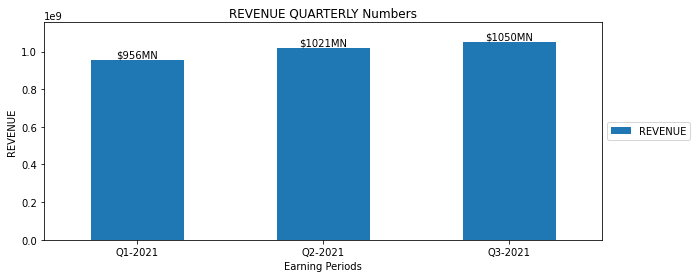

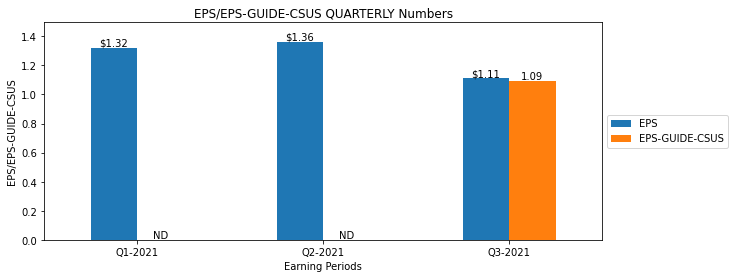

In [178]:
if(file and orgData and entities):
    val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
    basefile = os.path.basename(file)
    filename = os.path.splitext(basefile)[0]
    #print(filename)
    fsplit = filename.split("-")
    edate = fsplit[1]+"-"+fsplit[2]+"-"+fsplit[3].split("_")[0]
    #args = list()
    #print("EARNING DATE", edate)
    if(val):
        dobj = datetime.strptime(val, "%B")
        fynd = (dobj.month)
        allEntities["QTRS"] = getQtrs(csym, edate, fynd)
        #print(allEntities["QTRS"])
        
    for index,faq in enumerate(faqs):
        nf = False
        allEntities["SELF"] = None
        allEntities["SELF"] = dict()
        #print(faq["ENTITY"])
        for item in faq["ENTITY"]:
            #print(item, faq["ENTITY"][item])
            allEntities["SELF"]["*"+item] = faq["ENTITY"][item]
        if "FUNCTION" in faq:
            allEntities["SELF"]["*FUNCTION"] = faq["FUNCTION"]
        if "ARGS" in faq:
            allEntities["SELF"]["*ARGS"] = faq["ARGS"]
        if "FILTER" in faq:
            allEntities["SELF"]["*FILTER"] = faq["FILTER"]
        if "FILTERTYPE" in faq:
            allEntities["SELF"]["*FILTERTYPE"] = faq["FILTERTYPE"]
        if "FIELDS" in faq:
            allEntities["SELF"]["*FIELDS"] = faq["FIELDS"]
        if "SEARCH" in faq:
            allEntities["SELF"]["*SEARCH"] = faq["SEARCH"]
        if "INDEX" in faq:
            allEntities["SELF"]["*INDEX"] = faq["INDEX"]
        #print(allEntities["SELF"])
        print(str(index+1)+".", faq["Q"])
        ans = (faq["ANS"])
        #print(ans, faq["VARIABLES"])
        if "VARIABLES" not in faq or faq["VARIABLES"] is None:
            template = faq["TEMPLATE"]
            #print(template)
            #print(templates[template]["VARIABLES"])
            variables = templates[template]["VARIABLES"]
        else:
            variables = faq["VARIABLES"]
        for item in variables:
            var = item["VAR"]
            source = item["SOURCE"]
            how = item["HOW"]
            if "FIELD" not in item or item["FIELD"] is None:
                allEntities["SELF"][var] = getAttr(allEntities, source, None)
            else:
                field = item["FIELD"][0]
                if ("*" not in field and var not in allEntities["SELF"] and (how == "EXACT" or how == "TRANSFORMTOSTR")):
                    allEntities["SELF"][var] = getAttr(allEntities, item["SOURCE"], item["FIELD"][0])
                    if(how == "TRANSFORMTOSTR"):
                        allEntities["SELF"][var] = "\n".join(allEntities["SELF"][var])
                    if allEntities["SELF"][var] is None:
                        ans = faq["NF"]
                        print(ans)
                        print("\n")
                        nf = True
                        break
                elif("*" in field and var not in allEntities["SELF"] and (how == "EXACT" or how == "TRANSFORMTOSTR")):
                    #print(field)
                    for ent in allEntities["SELF"]:
                        if(ent in field):
                            field = field.replace(ent, allEntities["SELF"][ent])
                    #field = field.replace("*","")
                    #print(field, var, source)
                    #print(allEntities["ENTITIES"]["Q3-2021"]["REVENUE-RESULT"]["ISBEATSTR"])
                    allEntities["SELF"][var] = getAttr(allEntities, item["SOURCE"], field)
                    if(how == "TRANSFORMTOSTR"):
                        allEntities["SELF"][var] = "\n".join(allEntities["SELF"][var])
                    
                    if allEntities["SELF"][var] is None:
                        ans = faq["NF"]
                        print(ans)
                        print("\n")
                        nf = True
                        break
                elif(how == "APICALL"):
                    func = item["FIELD"][0]
                    if func in allEntities["SELF"]:
                        func = allEntities["SELF"][func]
                        #print(func)
                    args = item["FIELD"][1]
                    if args in allEntities["SELF"]:
                        args = allEntities["SELF"][args]
                    if not args:
                        ans = faq["NF"]
                        print(ans)
                        print("\n")
                        nf = True
                        break
                    for i,v in enumerate(args):
                        #if "*" in args[i] and args[i] in allEntities["SELF"]:
                        if "*" in args[i] and args[i] in allEntities["SELF"]:
                            #print(args[i])
                            args[i] = allEntities["SELF"][args[i]]
                            #print(args[i])
                    #print(args)
                    if not func or not args:
                        ans = faq["NF"]
                        print(ans)
                        print("\n")
                        nf = True
                        break
                    allEntities["SELF"][var] = wfunc(func, args)
                #print(field)
                #print(item["VAR"], item["SOURCE"], item["FIELD"][0], getAttr(allEntities, item["SOURCE"], item["FIELD"][0]))
        
        if not nf:
            if ans and ans != "*CHART" and ans != "*FRAME":
                for ent in allEntities["SELF"]:
                    if(ent in ans):
                        ans = ans.replace(ent, allEntities["SELF"][ent])
                #ans = ans.replace("*","")
                print(ans)
            elif ans and ans == "*CHART":
                showGraph(allEntities["SELF"]["*GDATA"])
            elif ans and ans == "*FRAME":
                print(allEntities["SELF"]["*FRAME"])
        
            print("\n")
            #print(allEntities["SELF"])

Text(0, 0.5, 'Revenue')

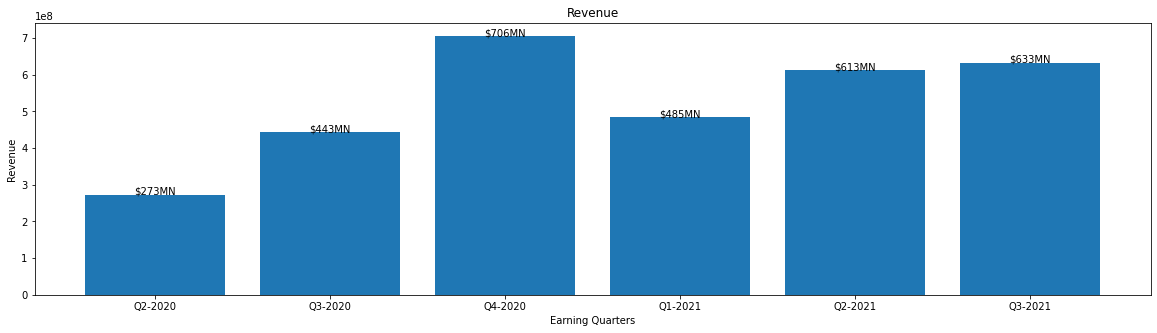

In [65]:
import matplotlib.pyplot as plt
import numpy as np
revenue = {"Q2-2020":273000000,"Q3-2020":443000000,"Q4-2020":706000000,"Q1-2021":485000000,"Q2-2021":613000000,"Q3-2021":633000000}
revtext = {"Q2-2020":"$273MN","Q3-2020":"$443MN","Q4-2020":"$706MN","Q1-2021":"$485MN","Q2-2021":"$613MN","Q3-2021":"$633MN"}
keys = revenue.keys()
#print(keys)
values = revenue.values()
plt.figure(figsize = (20,5))
plt.bar(keys, values, align='center')
for item in revenue:
    if(item in revtext):
        plt.text(item, revenue[item], (revtext[item]), ha = 'center')
#plt.bar(X_axis + 0.2, values, align='center')
plt.title("Revenue")
plt.xlabel("Earning Quarters")
plt.ylabel("Revenue")

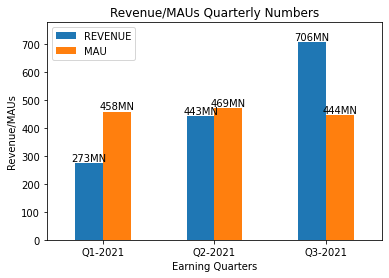

In [66]:
import pandas as pd
revenue = [273,443,706]
revenuetxt = ["273MN","443MN","706MN"]
mau = [458,469,444]
mautxt = ["458MN","469MN","444MN"]
index = ["Q1-2021","Q2-2021","Q3-2021"]
#print(revenue,mau,index)

df = pd.DataFrame(data={'REVENUE': revenue, 'MAU': mau}, index=index)
ax = df.plot(kind='bar', rot=0, xlabel='Earning Quarters', ylabel='Revenue/MAUs', title='Revenue/MAUs Quarterly Numbers', figsize=(6, 4))
for c in ax.containers:
    # set the bar label
    clbl = (c.get_label())
    if(clbl == "REVENUE"):
        ax.bar_label(c, labels=revenuetxt, fmt='%.0f', label_type='edge')
    else:
        ax.bar_label(c, labels=mautxt, fmt='%.0f', label_type='edge')

ax.margins(y=0.1)

{'DATA': {'REVENUE': [1142761000, 1692658000]}, 'TEXT': {'REVENUE': ['$1BN', '$2BN']}, 'INDEX': ['ALL-2019', 'ALL-2020'], 'FIELDS': ['REVENUE'], 'CALENDAR': 'Yearly'}


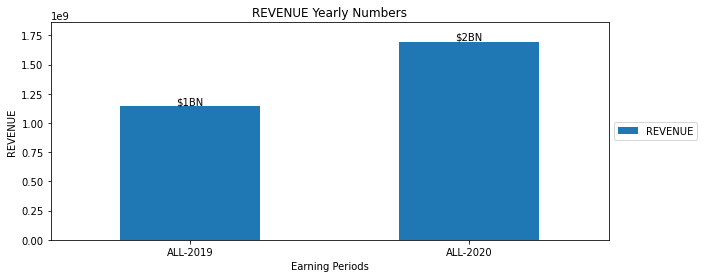

In [67]:
args = list()
args.append(allEntities["ENTITIES"])
#args.append("Q\d+-[0-9][0-9][0-9][0-9]")
args.append("ALL-[0-9][0-9][0-9][0-9]")
#fields = ["REVENUE","GLOBAL MONTHLY ACTIVE USERS"]
#fields = ["REVENUE-GUIDE-CSUS","REVENUE"]
fields = ["REVENUE"]
args.append(fields)
args.append("Yearly")
#args.append(8)
gData = getTableData(args)
print(gData)
showGraph(gData)

['GLOBAL MONTHLY ACTIVE USERS',
 'REVENUE - GLOBAL',
 'REVENUE - UNITED STATES',
 'REVENUE - INTERNATIONAL',
 'MONTHLY ACTIVE USERS - GLOBAL',
 'MONTHLY ACTIVE USERS - UNITED STATES',
 'MONTHLY ACTIVE USERS - INTERNATIONAL',
 'ACTIVE REVENUE PER USER - GLOBAL',
 'ACTIVE REVENUE PER USER - UNITED STATES',
 'ACTIVE REVENUE PER USER - INTERNATIONAL']

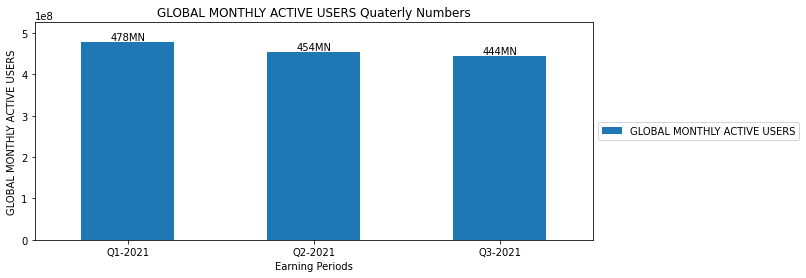

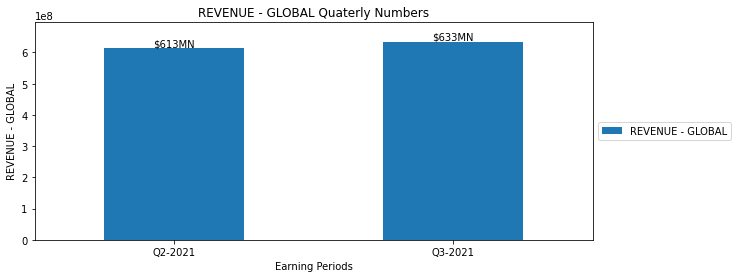

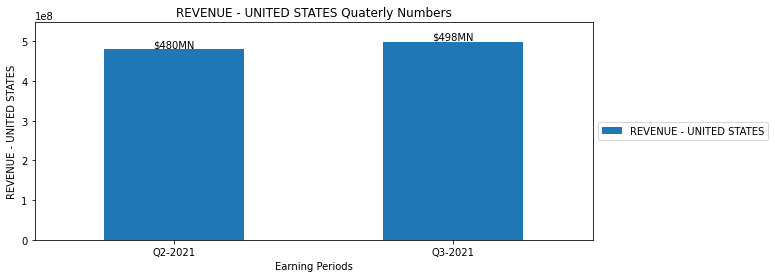

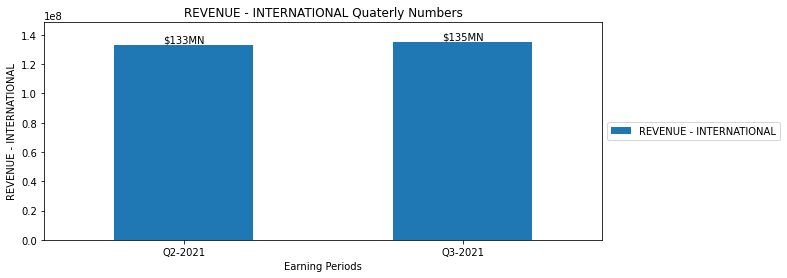

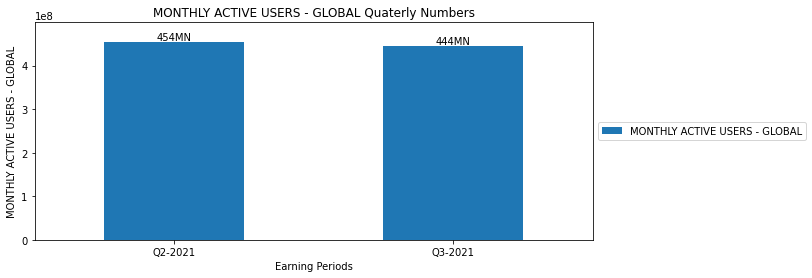

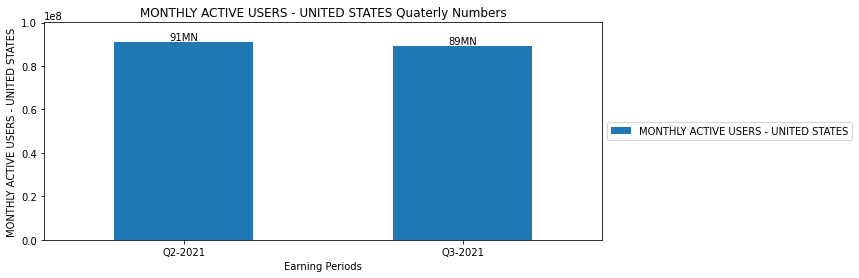

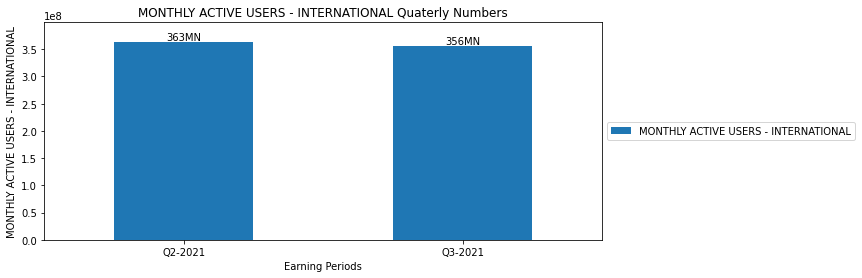

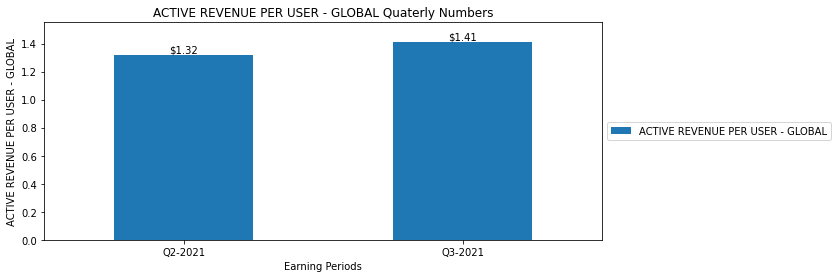

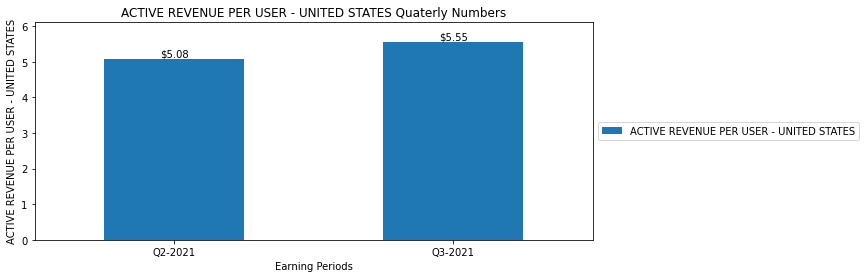

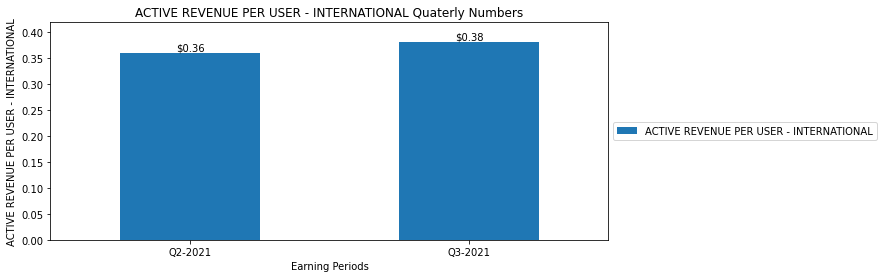

In [68]:
#args.append("ALL-[0-9][0-9][0-9][0-9]")
#fields = ["REVENUE","GLOBAL MONTHLY ACTIVE USERS"]
#fields = ["REVENUE-GUIDE-CSUS","REVENUE"]
args = list()
args.append(allEntities["ENTITIES"])
args.append("Q\d+-[0-9][0-9][0-9][0-9]")
args.append("Quaterly")
args.append("TEXT-METRICTYPE")
args.append("OPMETRIC")
showGraphWithCondition(args)

In [69]:
attr = getAttr(allEntities, "ORGDATA", "MAJORTRANS|ROSTERS")
#print(attr)
df = pd.read_json(attr)
#print(df)
index = "Individual or Entity"
search = "Most Recent Transaction"
df[index] = df[index].str.upper()
#print(df["Holder"])

newdf = df[df[search].str.contains("|".join(["Purchase","Sale"]))]
newdf = newdf.set_index(index)
#print(len(newdf))
if(len(newdf) > 0):
    print(newdf)
#print(df)

                                         Most Recent Transaction  \
Individual or Entity                                               
FLORES CHRISTINEGENERAL COUNSEL                             Sale   
GAVINI NAVEENOFFICER                                        Sale   
MORGENFELD TODD RCHIEF FINANCIAL OFFICER                    Sale   
YANG TSELI LILYOFFICER                                      Sale   

                                                  Date  \
Individual or Entity                                     
FLORES CHRISTINEGENERAL COUNSEL           Jun 27, 2021   
GAVINI NAVEENOFFICER                      Sep 12, 2021   
MORGENFELD TODD RCHIEF FINANCIAL OFFICER  Jun 27, 2021   
YANG TSELI LILYOFFICER                    Aug 26, 2021   

                                         Shares Owned as of Transaction Date  
Individual or Entity                                                          
FLORES CHRISTINEGENERAL COUNSEL                                       294872  
GAVIN